# <center>Introduction/Business Problem<center>

Chicago is a popular city for many individuals and families seeking to relocate. With a steady jobs market, unique neighborhoods and storied history, Chicago can be a home to people from many different backgrounds. However, given the myriad living options in Chicago, it can be difficult to choose the areas of the city that best fit the lifestyle choices, safety demands and housing budget of a prospective Chicagoan. 

According to [Forbes](https://www.forbes.com/sites/learnvest/2017/08/02/10-things-you-should-look-for-when-choosing-a-new-neighborhood/#1f21bf635fbc) and [Bankrate](https://www.bankrate.com/real-estate/how-to-find-a-good-neighborhood/), the top factors in choosing a neighborhood are:

 * Safety  
 * Home Prices/Rent
 * Socioeconomic indicators (per capita income, unemployment, etc.)
 * School Quality  
 * Proximity to Services (Public Transportation, Grocery, Dining, Shopping, Parks, etc.)

Identifying trends across safety, school quality, socioeconomic strata and services, suitable living areas can be identified and compared with the characteristics of individuals to determine which areas in the city best fit their desired lifestyles.

# <center>Data<center>

The data that will be used to solve this problem will be a combination of data from the [Chicago Data Portal](https://data.cityofchicago.org/), [Quandl API](https://blog.quandl.com) and the [Foursquare API](https://developer.foursquare.com/docs/). 

Safety/Crime Data will be sourced from the crime reports for the [Crimes - 2001 to present](https://data.cityofchicago.org/Public-Safety/Crimes-2020/qzdf-xmn8) dataset. This data clearly details the date, type, and location of crimes committed.

Rent for a specific ZIP code or community area will be found using the [Quandl API for Housing Data](https://blog.quandl.com/api-for-housing-data). This API allows unlimited calls and returns data for a location or ZIP code including Estimated Rent for all homes in the region, price-to-rent ratio and many other factors that play into changes in housing data over time.

Socioeconomic status and public health indicators will be used to determine the expense associated with living in a given community. This data will be sourced from the [Selected socioeconomic indicators 2008-2012 data](https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2) This data identifies overall socioeconomic factors and public health indicators for each of the community areas in Chicago, including per capita income, hardship index, and unemployment for those over the age of 16.

School Quality will be assessed using the [Chicago Public Schools - Progress Report Cards (2011-2012)](https://data.cityofchicago.org/Education/Chicago-Public-Schools-Progress-Report-Cards-2011-/9xs2-f89t) dataset. This dataset shows all school level performance data for 2011-2012.

Finally, the Foursquare API will be used to gather data on the services available to members of each of the Chicago community areas.

# <center> Data Methodology <center>

Import the necessary packages, and set the maximum row and column displays so we can see the full dataframe if we want.

In [90]:
# for basic dataframe and math operations
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np

# for plotting
import seaborn as sns

!conda install -c conda-forge geopy --yes # install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install quandl --yes; # install quandl for collecting rent information
import quandl

quandl_api_key = "b_KYkGKLvRCMEJ31kzjN" # user's quandl API key
quandl.ApiConfig.api_key = quandl_api_key

# for some arithmetic functions
import math

# import k-means from clustering sklearn package
from sklearn.cluster import KMeans

# install folium for map plotting 
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# to scale data for K-Means clustering
from sklearn.preprocessing import StandardScaler

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /Users/siyer/opt/anaconda3

  added / updated specs:
    - quandl


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.8.3-py37hc8dfbb8~ --> pkgs/main::conda-4.8.3-py37_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /Users/siyer/opt/anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


## <center> 1. Public School Performance Data <center>

### <center> Data Wrangling - Public School Data <center>

Let's import the public school data from the City of Chicago dataset.

In [2]:
school = pd.read_json('https://data.cityofchicago.org/resource/9xs2-f89t.json')

#### <center> Public School Community Area Table Extraction <center>

From the dataframe, we can extract the community area numbers and names as a separate dataframe and cross-reference with the community areas from the other datasets.

In [9]:
CA = school[['community_area_number','community_area_name']]

In [10]:
CA.shape

(566, 2)

Let's remove the duplicate community areas

In [11]:
CA = CA.drop_duplicates().sort_values("community_area_number")

And reset the index:

In [12]:
CA=CA.reset_index(drop=True)

There are 77 neighborhoods/community areas in Chicago - let's confirm this by checking the shape of school_ca

In [13]:
CA.shape

(77, 2)

In [14]:
CA

community_area_number     community_area_name
0                       1             ROGERS PARK
1                       2              WEST RIDGE
2                       3                  UPTOWN
3                       4          LINCOLN SQUARE
4                       5            NORTH CENTER
5                       6               LAKE VIEW
6                       7            LINCOLN PARK
7                       8         NEAR NORTH SIDE
8                       9             EDISON PARK
9                      10            NORWOOD PARK
10                     11          JEFFERSON PARK
11                     12             FOREST GLEN
12                     13              NORTH PARK
13                     14             ALBANY PARK
14                     15            PORTAGE PARK
15                     16             IRVING PARK
16                     17                 DUNNING
17                     18               MONTCLARE
18                     19          BELMONT CRAGIN
19                     20                 HERMOSA
20                     21                AVONDALE
21                     22            LOGAN SQUARE
22                     23           HUMBOLDT PARK
23                     24               WEST TOWN
24                     25                  AUSTIN
25                     26      WEST GARFIELD PARK
26                     27      EAST GARFIELD PARK
27                     28          NEAR WEST SIDE
28                     29          NORTH LAWNDALE
29                     30          SOUTH LAWNDALE
30                     31         LOWER WEST SIDE
31                     32                    LOOP
32                     33         NEAR SOUTH SIDE
33                     34           ARMOUR SQUARE
34                     35                 DOUGLAS
35                     36                 OAKLAND
36                     37             FULLER PARK
37                     38         GRAND BOULEVARD
38                     39                 KENWOOD
39                     40         WASHINGTON PARK
40                     41               HYDE PARK
41                     42                WOODLAWN
42                     43             SOUTH SHORE
43                     44                 CHATHAM
44                     45             AVALON PARK
45                     46           SOUTH CHICAGO
46                     47                BURNSIDE
47                     48         CALUMET HEIGHTS
48                     49                ROSELAND
49                     50                 PULLMAN
50                     51           SOUTH DEERING
51                     52               EAST SIDE
52                     53            WEST PULLMAN
53                     54               RIVERDALE
54                     55               HEGEWISCH
55                     56          GARFIELD RIDGE
56                     57          ARCHER HEIGHTS
57                     58           BRIGHTON PARK
58                     59           MCKINLEY PARK
59                     60              BRIDGEPORT
60                     61                NEW CITY
61                     62             WEST ELSDON
62                     63               GAGE PARK
63                     64                CLEARING
64                     65               WEST LAWN
65                     66            CHICAGO LAWN
66                     67          WEST ENGLEWOOD
67                     68               ENGLEWOOD
68                     69  GREATER GRAND CROSSING
69                     70                 ASHBURN
70                     71          AUBURN GRESHAM
71                     72                 BEVERLY
72                     73      WASHINGTON HEIGHTS
73                     74         MOUNT GREENWOOD
74                     75             MORGAN PARK
75                     76                   OHARE
76                     77               EDGEWATER

#### <center> Cleaning Data for CPS Dataframe <center>

Let's make CPS the dataframe of the school quality data and location data for each school. Since much of the information regarding graduation rate and college eligibility is unavailable for a majority of the schools recorded in the dataset, the Average Student Attendance, CPS Performance Policy Level and Safety Score will be used as our metrics for determining school quality.

In [24]:
cps = school[['school_id', 'name_of_school','average_student_attendance','cps_performance_policy_level', 'safety_score',
              'adequate_yearly_progress_made_','street_address', 'latitude','longitude','community_area_number','community_area_name','ward','police_district']]

The CPS Performance Policy Level is a good general indicator of school quality, so let's remove the invalid data.

In [16]:
cps['cps_performance_policy_level'].value_counts() # count the frequency of each Level occurrance

Level 2            215
Level 3            187
Level 1            139
Not Enough Data     20
NDA                  5
Name: cps_performance_policy_level, dtype: int64

Remove 'Not Enough Data' and 'NDA' rows from the field "CPS Performance Policy Level." Let's also remove invalid values from the 'adequate_yearly_progress_made_' field and encode the "Yes" and "No" responses to zeros and ones.

In [25]:
# select only the rows with valid data
cps = cps[(cps.cps_performance_policy_level=="Level 1")|(cps.cps_performance_policy_level=="Level 2")|
          (cps.cps_performance_policy_level=="Level 3")]

# remove the "Level" label from the data
cps['cps_performance_policy_level']=[int(a.split(" ")[-1]) for a in cps['cps_performance_policy_level']];

# remove records with "No Data Available" values
cps = cps[cps['adequate_yearly_progress_made_']!='NDA']

# Encode the "Yes" and "No" responses to 0 and 1
cps['adequate_yearly_progress_made_'].replace(to_replace=['No','Yes'],value=[0,1],inplace=True)

Let's look at some of the characteristics of the neighborhoods of Chicago to understand the distribution of school performance and safety.

In [26]:
cps_ca_perf=cps[['cps_performance_policy_level','community_area_name']]
cps_ca_perf

cps_performance_policy_level     community_area_name
0                               1            LINCOLN PARK
1                               1             SOUTH SHORE
2                               2                 ASHBURN
3                               1                NEW CITY
5                               1             ALBANY PARK
6                               1            NORTH CENTER
7                               3               WEST TOWN
9                               2             ALBANY PARK
10                              1            NORTH CENTER
11                              2                NEW CITY
12                              2               LAKE VIEW
13                              3               WEST TOWN
14                              2                ROSELAND
15                              3                ROSELAND
16                              2           HUMBOLDT PARK
17                              1                 BEVERLY
18                              3      EAST GARFIELD PARK
19                              2          NORTH LAWNDALE
20                              2         CALUMET HEIGHTS
21                              2            LOGAN SQUARE
22                              3               ENGLEWOOD
23                              2               WEST TOWN
24                              3                WOODLAWN
25                              1          NEAR WEST SIDE
26                              2          WEST ENGLEWOOD
27                              1         MOUNT GREENWOOD
28                              1               WEST TOWN
29                              3         GRAND BOULEVARD
30                              2                 KENWOOD
31                              3          WEST ENGLEWOOD
32                              3           SOUTH CHICAGO
33                              3                NEW CITY
34                              2                 CHATHAM
35                              1                 DUNNING
36                              3                 CHATHAM
37                              3          WEST ENGLEWOOD
38                              2                 ASHBURN
39                              1               LAKE VIEW
40                              3                  AUSTIN
41                              3                WOODLAWN
42                              2                  AUSTIN
43                              2             AVALON PARK
45                              2          BELMONT CRAGIN
46                              3         LOWER WEST SIDE
47                              3               ENGLEWOOD
48                              2               ENGLEWOOD
49                              2               WEST TOWN
50                              3         WASHINGTON PARK
51                              2                 KENWOOD
53                              3               HYDE PARK
54                              3           HUMBOLDT PARK
55                              1           BRIGHTON PARK
56                              3         GRAND BOULEVARD
57                              1           SOUTH DEERING
58                              2                 CHATHAM
59                              2           BRIGHTON PARK
60                              3             IRVING PARK
61                              1                AVONDALE
62                              2               ENGLEWOOD
63                              2                 ASHBURN
64                              3         GRAND BOULEVARD
65                              1                NEW CITY
66                              2          BELMONT CRAGIN
67                              3          NORTH LAWNDALE
68                              2                 ASHBURN
69                              2          SOUTH LAWNDALE
70                              2      WASHINGTON HEIGHTS
71                              3               HYDE PARK
72 

First, let's find the number of schools reporting in each community area.

In [27]:
ca_num_schools = cps_ca_perf.groupby('community_area_name').count()
ca_num_schools.rename(columns={'cps_performance_policy_level':'Number of Schools Reporting'},inplace=True)

In [28]:
ca_num_schools

Number of Schools Reporting
community_area_name                                
ALBANY PARK                                       8
ARCHER HEIGHTS                                    2
ARMOUR SQUARE                                     2
ASHBURN                                           8
AUBURN GRESHAM                                   10
AUSTIN                                           23
AVALON PARK                                       3
AVONDALE                                          3
BELMONT CRAGIN                                   10
BEVERLY                                           4
BRIDGEPORT                                        5
BRIGHTON PARK                                     8
BURNSIDE                                          1
CALUMET HEIGHTS                                   5
CHATHAM                                           9
CHICAGO LAWN                                      7
CLEARING                                          3
DOUGLAS                                          11
DUNNING                                           6
EAST GARFIELD PARK                               13
EAST SIDE                                         5
EDGEWATER                                         6
EDISON PARK                                       1
ENGLEWOOD                                        17
FOREST GLEN                                       3
FULLER PARK                                       2
GAGE PARK                                         8
GARFIELD RIDGE                                    5
GRAND BOULEVARD                                   8
GREATER GRAND CROSSING                           10
HEGEWISCH                                         2
HERMOSA                                           4
HUMBOLDT PARK                                    12
HYDE PARK                                         4
IRVING PARK                                       9
JEFFERSON PARK                                    2
KENWOOD                                           7
LAKE VIEW                                        11
LINCOLN PARK                                      7
LINCOLN SQUARE                                    5
LOGAN SQUARE                                     11
LOOP                                              1
LOWER WEST SIDE                                  11
MCKINLEY PARK                                     3
MONTCLARE                                         1
MORGAN PARK                                       4
MOUNT GREENWOOD                                   4
NEAR NORTH SIDE                                   6
NEAR SOUTH SIDE                                   2
NEAR WEST SIDE                                   14
NEW CITY                                         13
NORTH CENTER                                      6
NORTH LAWNDALE                                   15
NORTH PARK                                        4
NORWOOD PARK                                      7
OAKLAND                                           1
OHARE                                             1
PORTAGE PARK                                      6
PULLMAN                                           5
RIVERDALE                                         4
ROGERS PARK                                       6
ROSELAND                                         13
SOUTH CHICAGO                                     7
SOUTH DEERING                                     4
SOUTH LAWNDALE                                   21
SOUTH SHORE                                       8
UPTOWN                                            7
WASHINGTON HEIGHTS                                9
WASHINGTON PARK                                   5
WEST ELSDON                                       3
WEST ENGLEWOOD                                   12
WEST GARFIELD PARK                                8
WEST LAWN                                         3
WEST PULLMAN                                     10
WEST RIDGE                                        8
WEST TOWN           

Now let's find the average performance policy level for each community area. Since level 3 indicates lower performing schools, higher averages indicate poorer performing community areas.

In [29]:
# Find the mean policy level for each community area
avg_policy_level=cps_ca_perf.groupby('community_area_name').mean()

# Rename the Policy Level column to the Average Policy Level for each Community area
avg_policy_level.rename(columns={'cps_performance_policy_level':'average_performance_policy_level'}, inplace=True)

# Sort and assign this average policy level dataframe to be the CPS performance dataframe
cps_perf = avg_policy_level.sort_values('average_performance_policy_level')

In [24]:
cps_perf

average_performance_policy_level
community_area_name                                     
ARMOUR SQUARE                                   1.000000
FOREST GLEN                                     1.000000
LOOP                                            1.000000
OHARE                                           1.000000
EDISON PARK                                     1.000000
MONTCLARE                                       1.000000
NEAR SOUTH SIDE                                 1.000000
WEST RIDGE                                      1.125000
NORWOOD PARK                                    1.142857
NORTH CENTER                                    1.166667
MOUNT GREENWOOD                                 1.250000
NORTH PARK                                      1.250000
DUNNING                                         1.333333
CLEARING                                        1.333333
LAKE VIEW                                       1.363636
LINCOLN PARK                                    1.428571
JEFFERSON PARK                                  1.500000
UPTOWN                                          1.571429
CALUMET HEIGHTS                                 1.600000
BRIDGEPORT                                      1.600000
BRIGHTON PARK                                   1.625000
NEAR WEST SIDE                                  1.642857
AVONDALE                                        1.666667
PORTAGE PARK                                    1.666667
WEST LAWN                                       1.666667
BEVERLY                                         1.750000
WEST TOWN                                       1.777778
IRVING PARK                                     1.777778
EAST SIDE                                       1.800000
LINCOLN SQUARE                                  1.800000
ALBANY PARK                                     1.875000
ASHBURN                                         1.875000
LOWER WEST SIDE                                 1.909091
BURNSIDE                                        2.000000
SOUTH LAWNDALE                                  2.000000
WASHINGTON HEIGHTS                              2.000000
HEGEWISCH                                       2.000000
WEST ELSDON                                     2.000000
NEAR NORTH SIDE                                 2.000000
MCKINLEY PARK                                   2.000000
LOGAN SQUARE                                    2.000000
NEW CITY                                        2.076923
EAST GARFIELD PARK                              2.076923
CHATHAM                                         2.111111
EDGEWATER                                       2.166667
GARFIELD RIDGE                                  2.200000
PULLMAN                                         2.200000
GAGE PARK                                       2.250000
MORGAN PARK                                     2.250000
SOUTH DEERING                                   2.250000
HYDE PARK                                       2.250000
KENWOOD                                         2.285714
WEST PULLMAN                                    2.300000
ROGERS PARK                                     2.333333
AUSTIN                                          2.347826
ROSELAND                                        2.384615
BELMONT CRAGIN                                  2.400000
HUMBOLDT PARK                                   2.416667
DOUGLAS                                         2.454545
ARCHER HEIGHTS                                  2.500000
WEST ENGLEWOOD                                  2.500000
WEST GARFIELD PARK                              2.500000
HERMOSA                                         2.500000
GREATER GRAND CROSSING                          2.500000
ENGLEWOOD                                       2.529412
WASHINGTON PARK                                 2.600000
NORTH LAWNDALE                                  2.600000
SOUTH SHORE                                     2.625000
AVALON PARK                       

We can also average the "Adequate Yearly Progress Made" field for each Community Area to determine an "Adequate Yearly Progress Rate" metric for assessing overall school performance in each community area.

In [30]:
# create the CPS progress dataframe by selecting the community area and yearly progress fields
cps_prog = cps[['community_area_name','adequate_yearly_progress_made_']]

# Average the yearly progress rate field
ca_prog = cps_prog.groupby('community_area_name').mean()

#rename the column to the Adequate Yearly Progress Rate, as it represents all schools in the entire community area
ca_prog.rename(columns={'adequate_yearly_progress_made_':"Adequate Yearly Progress Rate"},inplace=True)

In [31]:
ca_prog

Adequate Yearly Progress Rate
community_area_name                                  
ALBANY PARK                                  0.250000
ARCHER HEIGHTS                               0.000000
ARMOUR SQUARE                                0.500000
ASHBURN                                      0.125000
AUBURN GRESHAM                               0.000000
AUSTIN                                       0.000000
AVALON PARK                                  0.000000
AVONDALE                                     0.000000
BELMONT CRAGIN                               0.000000
BEVERLY                                      0.500000
BRIDGEPORT                                   0.200000
BRIGHTON PARK                                0.000000
BURNSIDE                                     0.000000
CALUMET HEIGHTS                              0.400000
CHATHAM                                      0.222222
CHICAGO LAWN                                 0.000000
CLEARING                                     0.666667
DOUGLAS                                      0.090909
DUNNING                                      0.333333
EAST GARFIELD PARK                           0.076923
EAST SIDE                                    0.200000
EDGEWATER                                    0.000000
EDISON PARK                                  1.000000
ENGLEWOOD                                    0.000000
FOREST GLEN                                  1.000000
FULLER PARK                                  0.000000
GAGE PARK                                    0.000000
GARFIELD RIDGE                               0.200000
GRAND BOULEVARD                              0.000000
GREATER GRAND CROSSING                       0.000000
HEGEWISCH                                    0.000000
HERMOSA                                      0.000000
HUMBOLDT PARK                                0.000000
HYDE PARK                                    0.750000
IRVING PARK                                  0.111111
JEFFERSON PARK                               0.500000
KENWOOD                                      0.000000
LAKE VIEW                                    0.454545
LINCOLN PARK                                 0.428571
LINCOLN SQUARE                               0.200000
LOGAN SQUARE                                 0.090909
LOOP                                         1.000000
LOWER WEST SIDE                              0.000000
MCKINLEY PARK                                0.000000
MONTCLARE                                    0.000000
MORGAN PARK                                  0.000000
MOUNT GREENWOOD                              0.750000
NEAR NORTH SIDE                              0.333333
NEAR SOUTH SIDE                              0.500000
NEAR WEST SIDE                               0.357143
NEW CITY                                     0.000000
NORTH CENTER                                 0.500000
NORTH LAWNDALE                               0.066667
NORTH PARK                                   0.500000
NORWOOD PARK                                 0.428571
OAKLAND                                      0.000000
OHARE                                        0.000000
PORTAGE PARK                                 0.000000
PULLMAN                                      0.200000
RIVERDALE                                    0.000000
ROGERS PARK                                  0.000000
ROSELAND                                     0.076923
SOUTH CHICAGO                                0.000000
SOUTH DEERING                                0.250000
SOUTH LAWNDALE                               0.000000
SOUTH SHORE                                  0.000000
UPTOWN                                       0.000000
WASHINGTON HEIGHTS                           0.000000
WASHINGTON PARK                              0.200000
WEST ELSDON                                  0.000000
WEST ENGLEWOOD                               0.000000
WEST GARFIELD PARK                           0.000000
WEST LAWN                   

And now, let us join those dataframes together to make the composite community area performance dataframe.

In [32]:
# Join each dataframe together to make a master CPS performance dataframe
cps_perf=cps_perf.join(ca_num_schools, on='community_area_name');
cps_perf=cps_perf.join(ca_prog,on='community_area_name');

# Rename the column for consistency
cps_perf.rename(columns={'average_performance_policy_level':'Average Performance Policy Level'},inplace=True)

In [33]:
cps_perf

Average Performance Policy Level  \
community_area_name                                        
ARMOUR SQUARE                                   1.000000   
FOREST GLEN                                     1.000000   
LOOP                                            1.000000   
OHARE                                           1.000000   
EDISON PARK                                     1.000000   
MONTCLARE                                       1.000000   
NEAR SOUTH SIDE                                 1.000000   
WEST RIDGE                                      1.125000   
NORWOOD PARK                                    1.142857   
NORTH CENTER                                    1.166667   
MOUNT GREENWOOD                                 1.250000   
NORTH PARK                                      1.250000   
DUNNING                                         1.333333   
CLEARING                                        1.333333   
LAKE VIEW                                       1.363636   
LINCOLN PARK                                    1.428571   
JEFFERSON PARK                                  1.500000   
UPTOWN                                          1.571429   
CALUMET HEIGHTS                                 1.600000   
BRIDGEPORT                                      1.600000   
BRIGHTON PARK                                   1.625000   
NEAR WEST SIDE                                  1.642857   
AVONDALE                                        1.666667   
PORTAGE PARK                                    1.666667   
WEST LAWN                                       1.666667   
BEVERLY                                         1.750000   
WEST TOWN                                       1.777778   
IRVING PARK                                     1.777778   
EAST SIDE                                       1.800000   
LINCOLN SQUARE                                  1.800000   
ALBANY PARK                                     1.875000   
ASHBURN                                         1.875000   
LOWER WEST SIDE                                 1.909091   
BURNSIDE                                        2.000000   
SOUTH LAWNDALE                                  2.000000   
WASHINGTON HEIGHTS                              2.000000   
HEGEWISCH                                       2.000000   
WEST ELSDON                                     2.000000   
NEAR NORTH SIDE                                 2.000000   
MCKINLEY PARK                                   2.000000   
LOGAN SQUARE                                    2.000000   
NEW CITY                                        2.076923   
EAST GARFIELD PARK                              2.076923   
CHATHAM                                         2.111111   
EDGEWATER                                       2.166667   
GARFIELD RIDGE                                  2.200000   
PULLMAN                                         2.200000   
GAGE PARK                                       2.250000   
MORGAN PARK                                     2.250000   
SOUTH DEERING                                   2.250000   
HYDE PARK                                       2.250000   
KENWOOD                                         2.285714   
WEST PULLMAN                                    2.300000   
ROGERS PARK                                     2.333333   
AUSTIN                                          2.347826   
ROSELAND                                        2.384615   
BELMONT CRAGIN                                  2.400000   
HUMBOLDT PARK                                   2.416667   
DOUGLAS                                         2.454545   
ARCHER HEIGHTS                                  2.500000   
WEST ENGLEWOOD                                  2.500000   
WEST GARFIELD PARK                              2.500000   
HERMOSA                                         2.500000   
GREATER GRAND CROSSING                          2.500000   
ENGLEWOOD                                       2.529412   
WASH

To see how average performance policy level and adequate yearly progress rate are related to one another, let's plot the data against the other.

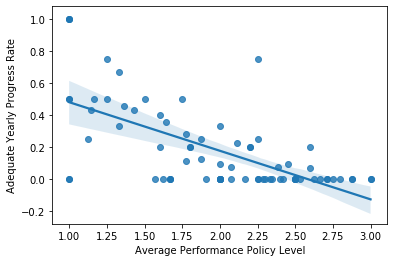

In [35]:
ax = sns.regplot(x='Average Performance Policy Level',y='Adequate Yearly Progress Rate', data=cps_perf)

In [36]:
cps_perf.reset_index(inplace=True)
cps_perf.shape

(77, 4)

We can observe that as the Average Performance Policy Level increases (the assessed school quality is poorer) the Adequate Yearly Progress Rate decreases. This indicates that these two variables are inversely proportional.

### <center> Latitude and Longitude Values for Community Areas in Chicago <center>

Let's use geopy to get latitude/longitude values for the community areas in Chicago.

In [38]:
geolocator = Nominatim(user_agent='chi_explorer')

In [39]:
lats = []
lngs = []

for ind,address in enumerate(school_ca['community_area_name']):
    chi_address = '{}, CHICAGO, IL'.format(address)
    location = geolocator.geocode(chi_address)
    lats.append(location.latitude)
    lngs.append(location.longitude)
    #print(chi_address)

#DO NOT UNCOMMENT AND RE-RUN, SOME LATITUDE AND LONGITUDE VALUES ARE INCORRECT AND WERE MANUALLY ADDED
#RUNNING WILL OVERWRITE
#school_ca['Latitude'] = lats
#school_ca['Longitude']=lngs

In [37]:
# ensure the indices match for performing the merge
school_ca.set_index('community_area_name');
cps_perf.set_index('community_area_name');

In [38]:
chi_ca = cps_perf.merge(school_ca)

Check the shape to ensure there are still 77 community areas covered

In [103]:
chi_ca.shape

(77, 7)

Now that each community area has its associated latitude and longitude values, let's reorder the columns to place the community area number at the beginning of the dataframe.

In [ ]:
# get the column names
newcols=chi_ca.columns.tolist()

# reoder the columns
chi_ca=chi_ca[[newcols[4]] + newcols[:4] + newcols[5:]]

# sort in order of the community areas and rename the community area to 'ca'
chi_ca.sort_values('community_area_number',ascending=True,inplace=True);
chi_ca=chi_ca.reset_index(drop=True)
chi_ca=chi_ca.rename(columns={'community_area_number':'ca'})
chi_ca

## <center> 2. Socioeconomic Indicator Data <center>

Now let's import the socioeconomic indicator data, drop the last row (extraneous data) and cast the community area number to an int so it can be used more readily for indexing.

In [40]:
df_soc = pd.read_json("https://data.cityofchicago.org/resource/kn9c-c2s2.json")

#drop extraneous data
df_soc.drop(77, axis=0,inplace=True)

#cast community area
df_soc['ca']=df_soc['ca'].astype(int)

Uppercase all of the community area names in the case that we need to join on them, so they match the other dataframes.

In [41]:
ca_upper = []
[ca_upper.append(a.upper()) for a in list(df_soc['community_area_name'])]
df_soc['community_area_name'] = ca_upper

Check that there are 77 rows, one for each community area.

In [42]:
df_soc.shape

(77, 9)

Since the previous City of Chicago data does not use an apostrophe in O'Hare, let's make it a convention that there is no apostrophe and make all instances of the name consistent.

In [44]:
df_soc.iloc[75,1]='OHARE'

In [45]:
df_soc

ca     community_area_name  percent_of_housing_crowded  \
0    1             ROGERS PARK                         7.7   
1    2              WEST RIDGE                         7.8   
2    3                  UPTOWN                         3.8   
3    4          LINCOLN SQUARE                         3.4   
4    5            NORTH CENTER                         0.3   
5    6               LAKE VIEW                         1.1   
6    7            LINCOLN PARK                         0.8   
7    8         NEAR NORTH SIDE                         1.9   
8    9             EDISON PARK                         1.1   
9   10            NORWOOD PARK                         2.0   
10  11          JEFFERSON PARK                         2.7   
11  12             FOREST GLEN                         1.1   
12  13              NORTH PARK                         3.9   
13  14             ALBANY PARK                        11.3   
14  15            PORTAGE PARK                         4.1   
15  16             IRVING PARK                         6.3   
16  17                 DUNNING                         5.2   
17  18              MONTCLAIRE                         8.1   
18  19          BELMONT CRAGIN                        10.8   
19  20                 HERMOSA                         6.9   
20  21                AVONDALE                         6.0   
21  22            LOGAN SQUARE                         3.2   
22  23           HUMBOLDT PARK                        14.8   
23  24               WEST TOWN                         2.3   
24  25                  AUSTIN                         6.3   
25  26      WEST GARFIELD PARK                         9.4   
26  27      EAST GARFIELD PARK                         8.2   
27  28          NEAR WEST SIDE                         3.8   
28  29          NORTH LAWNDALE                         7.4   
29  30          SOUTH LAWNDALE                        15.2   
30  31         LOWER WEST SIDE                         9.6   
31  32                    LOOP                         1.5   
32  33         NEAR SOUTH SIDE                         1.3   
33  34           ARMOUR SQUARE                         5.7   
34  35                 DOUGLAS                         1.8   
35  36                 OAKLAND                         1.3   
36  37             FULLER PARK                         3.2   
37  38         GRAND BOULEVARD                         3.3   
38  39                 KENWOOD                         2.4   
39  40         WASHINGTON PARK                         5.6   
40  41               HYDE PARK                         1.5   
41  42                WOODLAWN                         2.9   
42  43             SOUTH SHORE                         2.8   
43  44                 CHATHAM                         3.3   
44  45             AVALON PARK                         1.4   
45  46           SOUTH CHICAGO                         4.7   
46  47                BURNSIDE                         6.8   
47  48         CALUMET HEIGHTS                         2.1   
48  49                ROSELAND                         2.5   
49  50                 PULLMAN                         1.5   
50  51           SOUTH DEERING                         4.0   
51  52               EAST SIDE                         6.8   
52  53            WEST PULLMAN                         3.3   
53  54               RIVERDALE                         5.8   
54  55               HEGEWISCH                         3.3   
55  56          GARFIELD RIDGE                         2.6   
56  57          ARCHER HEIGHTS                         8.5   
57  58           BRIGHTON PARK                        14.4   
58  59           MCKINLEY PARK                         7.2   
59  60              BRIDGEPORT                         4.5   
60  61                NEW CITY                        11.9   
61  62             WEST ELSDON                        11.1   
62  63               GAGE PARK                        15.8   
63  64                CLEARING      

Now that we have the socioeconomic data, let's join the CPS performance data with the socioeconomic data.

In [ ]:
# merge the school data with the socioeconomic data
CHICAGO_FULL = chi_ca.merge(df_soc,on='ca')

# drop one community area name, since both are the same
CHICAGO_FULL=CHICAGO_FULL.drop(columns=['community_area_name_y'])

# rename the column of the left dataframe
CHICAGO_FULL=CHICAGO_FULL.rename(columns={'community_area_name_x':'community_area_name'})
CHICAGO_FULL

## <center> 3. Rent/Housing Price Data <center>

#### <center> Prepare Data for Use with Quandl <center>

Now we will use the Quandl API to get Housing Data for each of the community areas. First, let's get the postal code and the county for each of the community areas.

In [138]:
df = CHICAGO_FULL[['Latitude','Longitude']]
df.shape

(77, 2)

Let's use one of the earlier Labs to define the function to get the zipcodes for each community area using geopy.

In [141]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']

import geopy
geolocator = geopy.Nominatim(user_agent='chi-explorer')

zipcodes = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')
zipcodes.shape

(77,)

Insert the obtained zipcodes into the dataframe.

In [ ]:
CHICAGO_FULL.insert(7,'Postal Code',zipcodes)

Some of these values exceed our normal 5-digit postal code scheme for ZIP codes and some are also erroneous values, so these will be inserted into the CHICAGO_FULL dataframe.

In [148]:
CHICAGO_FULL['Postal Code'] = [val[0:5] for ind,val in enumerate(CHICAGO_FULL['Postal Code'])]
CHICAGO_FULL.iloc[3,7]='60625'
CHICAGO_FULL.iloc[37,7]='60615'

In [149]:
CHICAGO_FULL.shape

(77, 15)

Let's drop the "Percent of Housing Crowded" and "Percent aged under 18 or over 64" metrics because those are less relevant to the analysis.

In [152]:
CHICAGO_FULL=CHICAGO_FULL.drop(columns=['percent_aged_under_18_or_over_64','percent_of_housing_crowded'])

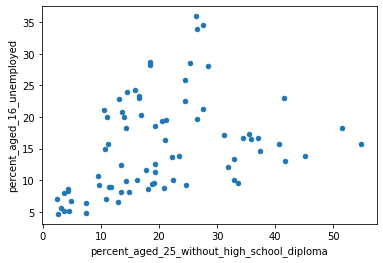

In [153]:
CHICAGO_FULL.plot(kind='scatter',y='percent_aged_16_unemployed',x='percent_aged_25_without_high_school_diploma')

Now let's save the CHICAGO_FULL dataframe to the csv file.

In [361]:
CHICAGO_FULL
CHICAGO_FULL.to_csv('CHICAGO_FULL.csv')

ca     community_area_name  Average Performance Policy Level  \
0    1             ROGERS PARK                          2.333333   
1    2              WEST RIDGE                          1.125000   
2    3                  UPTOWN                          1.571429   
3    4          LINCOLN SQUARE                          1.800000   
4    5            NORTH CENTER                          1.166667   
5    6               LAKE VIEW                          1.363636   
6    7            LINCOLN PARK                          1.428571   
7    8         NEAR NORTH SIDE                          2.000000   
8    9             EDISON PARK                          1.000000   
9   10            NORWOOD PARK                          1.142857   
10  11          JEFFERSON PARK                          1.500000   
11  12             FOREST GLEN                          1.000000   
12  13              NORTH PARK                          1.250000   
13  14             ALBANY PARK                          1.875000   
14  15            PORTAGE PARK                          1.666667   
15  16             IRVING PARK                          1.777778   
16  17                 DUNNING                          1.333333   
17  18               MONTCLARE                          1.000000   
18  19          BELMONT CRAGIN                          2.400000   
19  20                 HERMOSA                          2.500000   
20  21                AVONDALE                          1.666667   
21  22            LOGAN SQUARE                          2.000000   
22  23           HUMBOLDT PARK                          2.416667   
23  24               WEST TOWN                          1.777778   
24  25                  AUSTIN                          2.347826   
25  26      WEST GARFIELD PARK                          2.500000   
26  27      EAST GARFIELD PARK                          2.076923   
27  28          NEAR WEST SIDE                          1.642857   
28  29          NORTH LAWNDALE                          2.600000   
29  30          SOUTH LAWNDALE                          2.000000   
30  31         LOWER WEST SIDE                          1.909091   
31  32                    LOOP                          1.000000   
32  33         NEAR SOUTH SIDE                          1.000000   
33  34           ARMOUR SQUARE                          1.000000   
34  35                 DOUGLAS                          2.454545   
35  36                 OAKLAND                          3.000000   
36  37             FULLER PARK                          3.000000   
37  38         GRAND BOULEVARD                          2.875000   
38  39                 KENWOOD                          2.285714   
39  40         WASHINGTON PARK                          2.600000   
40  41               HYDE PARK                          2.250000   
41  42                WOODLAWN                          2.875000   
42  43             SOUTH SHORE                          2.625000   
43  44                 CHATHAM                          2.111111   
44  45             AVALON PARK                          2.666667   
45  46           SOUTH CHICAGO                          2.714286   
46  47                BURNSIDE                          2.000000   
47  48         CALUMET HEIGHTS                          1.600000   
48  49                ROSELAND                          2.384615   
49  50                 PULLMAN                          2.200000   
50  51           SOUTH DEERING                          2.250000   
51  52               EAST SIDE                          1.800000   
52  53            WEST PULLMAN                          2.300000   
53  54               RIVERDALE                          2.750000   
54  55               HEGEWISCH                          2.000000   
55  56          GARFIELD RIDGE                          2.200000   
56  57          ARCHER HEIGHTS                          2.500000   
57  58           BRIGHTON PARK                          1.62

In [51]:
CHICAGO_FULL = pd.read_csv('CHICAGO_FULL.csv')
CHICAGO_FULL.drop(columns=['Unnamed: 0'],inplace=True)

#### <center> Extract Neighborhood Codes from Quandl Website <center>

Now let's use Quandl API with the postal code information to get rent prices for each community area. Let's read in from our csv files and formulate the quandl api calls.

In [52]:
# read in the neighborhood codes
N_CODES = pd.read_csv('https://s3.amazonaws.com/quandl-production-static/zillow/neighborhood.txt',skiprows=1,
                      header=0,names=['Location','City','County','Code'])

N_CODES.dropna(axis=0,inplace=True) # drop nan values

N_CODES['City']=N_CODES['City'].str.strip() # remove the leading and trailing whitespace
N_CODES = N_CODES[N_CODES['City']=='Chicago'] # select only the neighborhood codes corresponding to Chicago
N_CODES['County']=N_CODES['County'].str.strip() # remove leading and trailing whitespace from County values
N_CODES['Location']=N_CODES['Location'].str.strip() # remove leading and trailing whitespace from Location values

N_CODES=N_CODES[N_CODES['County']!='Cook'] #there are some duplicate values, we'll use the ones that say "Cook County"

N_CODES = N_CODES.drop(columns=['City','County']) #drop the city and county columns, since everything is in Cook, Chicago

In [53]:
# Isolate the Codes, which are tied to another value
N_CODES['Code']=[i.split("|")[1] for i in N_CODES['Code']]

# Convert all the neighborhoods to uppercase to match with other data
N_CODES['Location']=[i.upper() for i in list(N_CODES['Location'])]

N_CODES=N_CODES.reset_index(drop=True)

The following codes rename neighborhood values that are synonymous between the two datasets to ensure that the Quandl neighborhood codes correspond with the correct community areas.

In [141]:
N_CODES.iloc[116,0]='NEAR NORTH SIDE'
N_CODES.iloc[128,0]='OHARE'

In [146]:
N_CODES.iloc[182,0]='LOOP'
N_CODES.drop(columns=0,inplace=True)

In [152]:
N_CODES.iloc[69,0]='AUBURN GRESHAM'

In [156]:
N_CODES.iloc[36,0]='BELMONT CRAGIN'

In [160]:
N_CODES.iloc[180,0]='DOUGLAS'

In [164]:
N_CODES.iloc[205,0]='WEST RIDGE'

In [168]:
N_CODES.iloc[132,0]='NORWOOD PARK'

In [172]:
N_CODES.iloc[167,0]='AUSTIN'

In [176]:
N_CODES.iloc[78,0]='NORTH LAWNDALE'

In [180]:
N_CODES.iloc[38,0]='SOUTH LAWNDALE'

In [186]:
N_CODES.iloc[141,0]='LOWER WEST SIDE'

In [190]:
N_CODES.iloc[172,0]='NEAR SOUTH SIDE'

In [194]:
N_CODES.iloc[32,0]='ARMOUR SQUARE'

In [198]:
N_CODES.iloc[21,0]='GRAND BOULEVARD'

In [202]:
N_CODES.iloc[8,0]='NEW CITY'

In [206]:
N_CODES.iloc[67,0]='GREATER GRAND CROSSING'

Merge the community area information with the neighborhood codes and save to csv for later retrieval.

In [208]:
#merge reference table with the neighborhood codes
CA_NCODES=pd.merge(CA_REF_TABLE, N_CODES.rename(columns={'Location':'ca_name'}), how='left').sort_values('Code')

#save to csv
CA_NCODES.to_csv('N_CODES.csv')

In [ ]:
CA_NCODES=pd.read_csv('N_CODES.csv')
CA_NCODES=CA_NCODES.drop(columns='Unnamed: 0')
CA_NCODES=CA_NCODES.sort_values('ca')

In [4]:
CA_NCODES

ca                 ca_name   Code
6    1             ROGERS PARK  10446
1    2              WEST RIDGE  10391
26   3                  UPTOWN  10755
62   4          LINCOLN SQUARE  12823
29   5            NORTH CENTER  10797
4    6               LAKE VIEW  10440
40   7            LINCOLN PARK  11021
27   8         NEAR NORTH SIDE  10760
45   9             EDISON PARK  11187
66  10            NORWOOD PARK  14866
9   11          JEFFERSON PARK  10491
71  12             FOREST GLEN  17367
61  13              NORTH PARK  12795
3   14             ALBANY PARK  10433
10  15            PORTAGE PARK  10498
54  16             IRVING PARK  11879
65  17                 DUNNING  13586
39  18               MONTCLARE  10974
17  19          BELMONT CRAGIN  10550
63  20                 HERMOSA  12996
34  21                AVONDALE  10885
0   22            LOGAN SQUARE  10356
12  23           HUMBOLDT PARK  10518
24  24               WEST TOWN  10707
2   25                  AUSTIN  10424
56  26      WEST GARFIELD PARK  12427
28  27      EAST GARFIELD PARK  10767
38  28          NEAR WEST SIDE  10958
73  29          NORTH LAWNDALE  35829
75  30          SOUTH LAWNDALE  36986
60  31         LOWER WEST SIDE  12742
44  32                    LOOP  11127
11  33         NEAR SOUTH SIDE  10517
69  34           ARMOUR SQUARE  15281
70  35                 DOUGLAS  15971
67  36                 OAKLAND  14892
74  37             FULLER PARK  36055
20  38         GRAND BOULEVARD  10621
47  39                 KENWOOD  11374
59  40         WASHINGTON PARK  12741
32  41               HYDE PARK  10826
42  42                WOODLAWN  11036
16  43             SOUTH SHORE  10535
49  44                 CHATHAM  11779
68  45             AVALON PARK  15083
23  46           SOUTH CHICAGO  10691
46  47                BURNSIDE  11315
50  48         CALUMET HEIGHTS  11786
30  49                ROSELAND  10802
72  50                 PULLMAN  18090
57  51           SOUTH DEERING  12455
48  52               EAST SIDE  11777
22  53            WEST PULLMAN  10665
76  54               RIVERDALE  42228
51  55               HEGEWISCH  11792
21  56          GARFIELD RIDGE  10650
5   57          ARCHER HEIGHTS  10441
52  58           BRIGHTON PARK  11819
64  59           MCKINLEY PARK  13170
14  60              BRIDGEPORT  10521
18  61                NEW CITY  10568
31  62             WEST ELSDON  10807
13  63               GAGE PARK  10520
33  64                CLEARING  10859
19  65               WEST LAWN  10571
53  66            CHICAGO LAWN  11856
25  67          WEST ENGLEWOOD  10740
8   68               ENGLEWOOD  10489
58  69  GREATER GRAND CROSSING  12707
41  70                 ASHBURN  11031
7   71          AUBURN GRESHAM  10477
43  72                 BEVERLY  11041
55  73      WASHINGTON HEIGHTS  12174
36  74         MOUNT GREENWOOD  10903
35  75             MORGAN PARK  10891
37  76                   OHARE  10945
15  77               EDGEWATER  10522

Now let's create a dictionary to store the rent for each community area once we obtain it from Quandl.

In [8]:
rent={}

This script will collect the rent values from Quandl and print those that could not be found.

In [10]:
for i in np.arange(0,CA_NCODES.shape[0]):
    try:
        r = list(quandl.get('ZILLOW/N{}_MRPAH'.format(CA_NCODES.iloc[i,2]))['Value'])[-1]
        print("Found! Median Rent in {} is {}".format(CA_NCODES.iloc[i,1],r))
        rent[CA_NCODES.iloc[i,1]]=r
    except:
        print("Median Rent in {}, ({}) could not be found".format(CA_NCODES.iloc[i,1],CA_NCODES.iloc[i,2]))
        rent[CA_NCODES.iloc[i,1]]=None

Found! Median Rent in ROGERS PARK is 1350.0
Found! Median Rent in WEST RIDGE is 1250.0
Found! Median Rent in UPTOWN is 1425.0
Median Rent in LINCOLN SQUARE, (12823) could not be found
Median Rent in NORTH CENTER, (10797) could not be found
Found! Median Rent in LAKE VIEW is 1900.0
Found! Median Rent in LINCOLN PARK is 1800.0
Found! Median Rent in NEAR NORTH SIDE is 1900.0
Median Rent in EDISON PARK, (11187) could not be found
Median Rent in NORWOOD PARK, (14866) could not be found
Median Rent in JEFFERSON PARK, (10491) could not be found
Median Rent in FOREST GLEN, (17367) could not be found
Median Rent in NORTH PARK, (12795) could not be found
Found! Median Rent in ALBANY PARK is 1395.0
Median Rent in PORTAGE PARK, (10498) could not be found
Median Rent in IRVING PARK, (11879) could not be found
Median Rent in DUNNING, (13586) could not be found
Median Rent in MONTCLARE, (10974) could not be found
Median Rent in BELMONT CRAGIN, (10550) could not be found
Median Rent in HERMOSA, (12996

Convert the rent dictionary to a dataframe.

In [30]:
df_rent = pd.DataFrame(list(rent.items()))
df_rent

0       1
0              ROGERS PARK  1350.0
1               WEST RIDGE  1250.0
2                   UPTOWN  1425.0
3           LINCOLN SQUARE     NaN
4             NORTH CENTER     NaN
5                LAKE VIEW  1900.0
6             LINCOLN PARK  1800.0
7          NEAR NORTH SIDE  1900.0
8              EDISON PARK     NaN
9             NORWOOD PARK     NaN
10          JEFFERSON PARK     NaN
11             FOREST GLEN     NaN
12              NORTH PARK     NaN
13             ALBANY PARK  1395.0
14            PORTAGE PARK     NaN
15             IRVING PARK     NaN
16                 DUNNING     NaN
17               MONTCLARE     NaN
18          BELMONT CRAGIN     NaN
19                 HERMOSA     NaN
20                AVONDALE     NaN
21            LOGAN SQUARE  1775.0
22           HUMBOLDT PARK  1572.5
23               WEST TOWN  2400.0
24                  AUSTIN  1020.0
25      WEST GARFIELD PARK     NaN
26      EAST GARFIELD PARK     NaN
27          NEAR WEST SIDE  2504.0
28          NORTH LAWNDALE     NaN
29          SOUTH LAWNDALE     NaN
30         LOWER WEST SIDE     NaN
31                    LOOP  2000.0
32         NEAR SOUTH SIDE  2103.0
33           ARMOUR SQUARE     NaN
34                 DOUGLAS     NaN
35                 OAKLAND     NaN
36             FULLER PARK     NaN
37         GRAND BOULEVARD  1650.0
38                 KENWOOD     NaN
39         WASHINGTON PARK     NaN
40               HYDE PARK     NaN
41                WOODLAWN  1475.0
42             SOUTH SHORE  1100.0
43                 CHATHAM     NaN
44             AVALON PARK     NaN
45           SOUTH CHICAGO  1287.5
46                BURNSIDE     NaN
47         CALUMET HEIGHTS     NaN
48                ROSELAND  1287.5
49                 PULLMAN     NaN
50           SOUTH DEERING     NaN
51               EAST SIDE     NaN
52            WEST PULLMAN  1350.0
53               RIVERDALE     NaN
54               HEGEWISCH     NaN
55          GARFIELD RIDGE     NaN
56          ARCHER HEIGHTS     NaN
57           BRIGHTON PARK     NaN
58           MCKINLEY PARK     NaN
59              BRIDGEPORT     NaN
60                NEW CITY     NaN
61             WEST ELSDON     NaN
62               GAGE PARK     NaN
63                CLEARING     NaN
64               WEST LAWN     NaN
65            CHICAGO LAWN     NaN
66          WEST ENGLEWOOD     NaN
67               ENGLEWOOD  1275.0
68  GREATER GRAND CROSSING  1150.0
69                 ASHBURN     NaN
70          AUBURN GRESHAM  1253.0
71                 BEVERLY     NaN
72      WASHINGTON HEIGHTS     NaN
73         MOUNT GREENWOOD     NaN
74             MORGAN PARK     NaN
75                   OHARE     NaN
76               EDGEWATER  1400.0

Let's rename the columns to correspond with the data they actually represent.

In [51]:
df_rent.rename(columns={'ca':'community_area_name',1:'Median Rent'},inplace=True)
CA_REF=CHICAGO_FULL[['ca','community_area_name']]
df_rent = CA_REF.merge(df_rent)

In [67]:
df_rent

ca     community_area_name  Median Rent
0    1             ROGERS PARK       1350.0
1    2              WEST RIDGE       1250.0
2    3                  UPTOWN       1425.0
3    4          LINCOLN SQUARE          NaN
4    5            NORTH CENTER          NaN
5    6               LAKE VIEW       1900.0
6    7            LINCOLN PARK       1800.0
7    8         NEAR NORTH SIDE       1900.0
8    9             EDISON PARK          NaN
9   10            NORWOOD PARK          NaN
10  11          JEFFERSON PARK          NaN
11  12             FOREST GLEN          NaN
12  13              NORTH PARK          NaN
13  14             ALBANY PARK       1395.0
14  15            PORTAGE PARK          NaN
15  16             IRVING PARK          NaN
16  17                 DUNNING          NaN
17  18               MONTCLARE          NaN
18  19          BELMONT CRAGIN          NaN
19  20                 HERMOSA          NaN
20  21                AVONDALE          NaN
21  22            LOGAN SQUARE       1775.0
22  23           HUMBOLDT PARK       1572.5
23  24               WEST TOWN       2400.0
24  25                  AUSTIN       1020.0
25  26      WEST GARFIELD PARK          NaN
26  27      EAST GARFIELD PARK          NaN
27  28          NEAR WEST SIDE       2504.0
28  29          NORTH LAWNDALE          NaN
29  30          SOUTH LAWNDALE          NaN
30  31         LOWER WEST SIDE          NaN
31  32                    LOOP       2000.0
32  33         NEAR SOUTH SIDE       2103.0
33  34           ARMOUR SQUARE          NaN
34  35                 DOUGLAS          NaN
35  36                 OAKLAND          NaN
36  37             FULLER PARK          NaN
37  38         GRAND BOULEVARD       1650.0
38  39                 KENWOOD          NaN
39  40         WASHINGTON PARK          NaN
40  41               HYDE PARK          NaN
41  42                WOODLAWN       1475.0
42  43             SOUTH SHORE       1100.0
43  44                 CHATHAM          NaN
44  45             AVALON PARK          NaN
45  46           SOUTH CHICAGO       1287.5
46  47                BURNSIDE          NaN
47  48         CALUMET HEIGHTS          NaN
48  49                ROSELAND       1287.5
49  50                 PULLMAN          NaN
50  51           SOUTH DEERING          NaN
51  52               EAST SIDE          NaN
52  53            WEST PULLMAN       1350.0
53  54               RIVERDALE          NaN
54  55               HEGEWISCH          NaN
55  56          GARFIELD RIDGE          NaN
56  57          ARCHER HEIGHTS          NaN
57  58           BRIGHTON PARK          NaN
58  59           MCKINLEY PARK          NaN
59  60              BRIDGEPORT          NaN
60  61                NEW CITY          NaN
61  62             WEST ELSDON          NaN
62  63               GAGE PARK          NaN
63  64                CLEARING          NaN
64  65               WEST LAWN          NaN
65  66            CHICAGO LAWN          NaN
66  67          WEST ENGLEWOOD          NaN
67  68               ENGLEWOOD       1275.0
68  69  GREATER GRAND CROSSING       1150.0
69  70                 ASHBURN          NaN
70  71          AUBURN GRESHAM       1253.0
71  72                 BEVERLY          NaN
72  73      WASHINGTON HEIGHTS          NaN
73  74         MOUNT GREENWOOD          NaN
74  75             MORGAN PARK          NaN
75  76                   OHARE          NaN
76  77               EDGEWATER       1400.0

Since there were serveral NaN values returned using the neighborhhood codes, let's try to fill in the remaining rent prices using the zipcodes.

In [91]:
for i in np.arange(0,df_rent.shape[0]):
    if math.isnan(df_rent.iloc[i,2]):
        try:
            r= list(quandl.get('ZILLOW/Z{}_MRP1B'.format(CHICAGO_FULL['Postal Code'][i]))['Value'])[-1]
            print('Rent for {} is {}'.format(df_rent.iloc[i,1],r))
            df_rent.iloc[i,2] = r
        except:
            print("Rent not found for {}".format(df_rent.iloc[i,1]))


Rent not found for EDISON PARK
Rent not found for NORWOOD PARK
Rent not found for FOREST GLEN
Rent not found for KENWOOD
Rent not found for HEGEWISCH
Rent not found for GARFIELD RIDGE
Rent not found for BRIGHTON PARK
Rent not found for WEST ELSDON
Rent not found for CLEARING
Rent not found for WEST LAWN
Rent not found for ASHBURN
Rent not found for MOUNT GREENWOOD
Rent not found for OHARE


Since there are still remaining NaN values, we will replace them with the median rent price of all homes in Chicago.

In [93]:
# gets the value of the median rent in the city of chicago
mrpah_chicago = list(quandl.get('ZILLOW/C19469_MRPAH')['Value'])[-1]

# fills the NaN values in the dataframe with the median rent of the city of chicago
df_rent['Median Rent'].fillna(mrpah_chicago,inplace=True)

# merges the rent dataframe with the CHICAGO_FULL dataframe, adding the housing data
CHICAGO_FULL = CHICAGO_FULL.merge(df_rent)

Let's save the CHICAGO_FULL dataframe to the csv so that we can recover this data easily.

In [102]:
CHICAGO_FULL.to_csv('CHICAGO_FULL.csv')

In [54]:
CHICAGO = pd.read_csv('CHICAGO_FULL.csv')
CHICAGO.drop(columns=['Unnamed: 0'],inplace=True)

By plotting and using linear regression, we can see that percent_households_below_poverty, percent_aged_16_unemployed, percent_aged_25_without_high_school_diploma, and hardship_index are all related in the same way. Since hardship_index accounts for these factors and is also already normalized, let's drop the other three and use the hardship index.

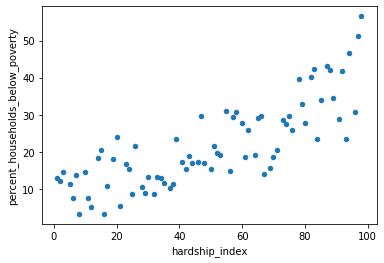

In [55]:
CHICAGO.plot(kind='scatter',x='hardship_index',y='percent_households_below_poverty')

In [56]:
CHICAGO.drop(columns=['percent_households_below_poverty','percent_aged_16_unemployed','percent_aged_25_without_high_school_diploma'],inplace=True)

In [57]:
CHICAGO

ca     community_area_name  Average Performance Policy Level  \
0    1             ROGERS PARK                          2.333333   
1    2              WEST RIDGE                          1.125000   
2    3                  UPTOWN                          1.571429   
3    4          LINCOLN SQUARE                          1.800000   
4    5            NORTH CENTER                          1.166667   
5    6               LAKE VIEW                          1.363636   
6    7            LINCOLN PARK                          1.428571   
7    8         NEAR NORTH SIDE                          2.000000   
8    9             EDISON PARK                          1.000000   
9   10            NORWOOD PARK                          1.142857   
10  11          JEFFERSON PARK                          1.500000   
11  12             FOREST GLEN                          1.000000   
12  13              NORTH PARK                          1.250000   
13  14             ALBANY PARK                          1.875000   
14  15            PORTAGE PARK                          1.666667   
15  16             IRVING PARK                          1.777778   
16  17                 DUNNING                          1.333333   
17  18               MONTCLARE                          1.000000   
18  19          BELMONT CRAGIN                          2.400000   
19  20                 HERMOSA                          2.500000   
20  21                AVONDALE                          1.666667   
21  22            LOGAN SQUARE                          2.000000   
22  23           HUMBOLDT PARK                          2.416667   
23  24               WEST TOWN                          1.777778   
24  25                  AUSTIN                          2.347826   
25  26      WEST GARFIELD PARK                          2.500000   
26  27      EAST GARFIELD PARK                          2.076923   
27  28          NEAR WEST SIDE                          1.642857   
28  29          NORTH LAWNDALE                          2.600000   
29  30          SOUTH LAWNDALE                          2.000000   
30  31         LOWER WEST SIDE                          1.909091   
31  32                    LOOP                          1.000000   
32  33         NEAR SOUTH SIDE                          1.000000   
33  34           ARMOUR SQUARE                          1.000000   
34  35                 DOUGLAS                          2.454545   
35  36                 OAKLAND                          3.000000   
36  37             FULLER PARK                          3.000000   
37  38         GRAND BOULEVARD                          2.875000   
38  39                 KENWOOD                          2.285714   
39  40         WASHINGTON PARK                          2.600000   
40  41               HYDE PARK                          2.250000   
41  42                WOODLAWN                          2.875000   
42  43             SOUTH SHORE                          2.625000   
43  44                 CHATHAM                          2.111111   
44  45             AVALON PARK                          2.666667   
45  46           SOUTH CHICAGO                          2.714286   
46  47                BURNSIDE                          2.000000   
47  48         CALUMET HEIGHTS                          1.600000   
48  49                ROSELAND                          2.384615   
49  50                 PULLMAN                          2.200000   
50  51           SOUTH DEERING                          2.250000   
51  52               EAST SIDE                          1.800000   
52  53            WEST PULLMAN                          2.300000   
53  54               RIVERDALE                          2.750000   
54  55               HEGEWISCH                          2.000000   
55  56          GARFIELD RIDGE                          2.200000   
56  57          ARCHER HEIGHTS                          2.500000   
57  58           BRIGHTON PARK                          1.62

## <center> 4. Crime Data <center>

Now let's read in the crime data and display it.

In [58]:
crimes = pd.read_csv('Crimes_-_2020.csv')
crimes.head()

ID Case Number                    Date                 Block  IUCR  \
0  12084255    JD271508  06/21/2020 04:15:00 PM   050XX S CORNELL AVE  031A   
1  12083825    JD271026  06/21/2020 02:12:00 AM       006XX E 44TH ST  041A   
2  12083898    JD271075  06/21/2020 03:46:00 AM       001XX E 95TH ST  1310   
3  12084166    JD271377  06/21/2020 01:26:00 PM    075XX N SEELEY AVE  0486   
4  12088654    JD276641  02/05/2020 08:00:00 AM  066XX N LAKEWOOD AVE  1153   

         Primary Type                          Description  \
0             ROBBERY                      ARMED - HANDGUN   
1             BATTERY                 AGGRAVATED - HANDGUN   
2     CRIMINAL DAMAGE                          TO PROPERTY   
3             BATTERY              DOMESTIC BATTERY SIMPLE   
4  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   

  Location Description  Arrest  Domestic  Beat  District  Ward  \
0          GAS STATION   False     False   222         2   5.0   
1      OTHER (SPECIFY)   False     False   221         2   4.0   
2      OTHER (SPECIFY)   False     False   634         6   9.0   
3            APARTMENT   False      True  2424        24  49.0   
4            APARTMENT   False     False  2432        24  49.0   

   Community Area FBI Code  X Coordinate  Y Coordinate  Year  \
0              39       03     1187887.0     1871709.0  2020   
1              38      04B     1181468.0     1875986.0  2020   
2              49       14     1178956.0     1842018.0  2020   
3               1      08B     1161338.0     1949989.0  2020   
4               1       11     1166340.0     1944321.0  2020   

               Updated On   Latitude  Longitude                       Location  
0  06/28/2020 03:47:32 PM  41.803057 -87.586453  (41.803056534, -87.586453094)  
1  06/28/2020 03:47:32 PM  41.814944 -87.609862  (41.814943616, -87.609862202)  
2  06/28/2020 03:47:32 PM  41.721789 -87.620110  (41.721789488, -87.620109702)  
3  06/28/2020 03:47:32 PM  42.018454 -87.681639  (42.018454423, -87.681639143)  
4  06/28/2020 03:45:35 PM  42.002795 -87.663396  (42.002795364, -87.663395916)

Extract the Community area and year of each crime. Since we only care about total crimes in each community area, we can group the crimes by community area and count them.

In [61]:
ca_crime = crimes[['Community Area','Year']]

numcrimes = ca_crime.groupby('Community Area').count().rename(columns={'Year':'Number of Crimes 2001-present'})

numcrimes.reset_index(inplace=True)
numcrimes.rename(columns={'Community Area':'ca'},inplace=True)
numcrimes

ca  Number of Crimes 2001-present
0    1                           1471
1    2                           1266
2    3                           1257
3    4                            792
4    5                            512
5    6                           1895
6    7                           1280
7    8                           3379
8    9                             96
9   10                            350
10  11                            379
11  12                            215
12  13                            326
13  14                            867
14  15                           1116
15  16                            989
16  17                            538
17  18                            230
18  19                           1637
19  20                            543
20  21                            788
21  22                           1750
22  23                           3002
23  24                           2264
24  25                           5788
25  26                           2233
26  27                           1756
27  28                           2935
28  29                           3253
29  30                           1675
30  31                            967
31  32                           2596
32  33                            708
33  34                            379
34  35                            957
35  36                            236
36  37                            351
37  38                           1322
38  39                            496
39  40                            868
40  41                            580
41  42                           1305
42  43                           3594
43  44                           2564
44  45                            559
45  46                           1449
46  47                            157
47  48                            567
48  49                           2670
49  50                            397
50  51                            729
51  52                            408
52  53                           1751
53  54                            519
54  55                            222
55  56                            670
56  57                            315
57  58                            805
58  59                            323
59  60                            557
60  61                           1704
61  62                            331
62  63                            776
63  64                            391
64  65                            587
65  66                           2296
66  67                           2570
67  68                           2393
68  69                           2692
69  70                            849
70  71                           2794
71  72                            334
72  73                           1173
73  74                            192
74  75                            747
75  76                            480
76  77                           1036

Merge the Crime data with the CHICAGO dataframe to round out the non-Foursquare data.

In [62]:
CHICAGO = CHICAGO.merge(numcrimes)
CHICAGO.to_csv('CHICAGO.csv')

## <center> 5. Foursquare Data <center>

Now, let's use Foursquare to find out the top 5 venues in proximity to each community area location.

#### Define Foursquare Credentials and Version

In [104]:
CLIENT_ID = 'RMGLSZNSF0E2O4ZDM2RUE54HPXOYLX105EHCSIOAZYKGINFM' # your Foursquare ID
CLIENT_SECRET = 'NK1W0BWWHDOEO4Q1XG5KNCK2PUIDNEFKINVYV1SCU42FHIY1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [105]:
LIMIT = 100;
radius= 1200;
url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},\
{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    CHICAGO.iloc[53,5],
    CHICAGO.iloc[53,6],
    radius,
    LIMIT)

In [106]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

####  Let's create a function to repeat this for all neighborhoods

In [108]:
def getNearbyVenues(names, latitudes, longitudes, radius=1200, LIMIT=100):
    
    i = 1;
    print(radius, LIMIT)
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("{} {}".format(i,name))
        i = i+1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print(requests.get(url).json()['response'])
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [109]:
chicago_venues = getNearbyVenues(names=CHICAGO['community_area_name'],
                                latitudes = CHICAGO['Latitude'],
                                longitudes= CHICAGO['Longitude'])

1200 100
1 ROGERS PARK
2 WEST RIDGE
3 UPTOWN
4 LINCOLN SQUARE
5 NORTH CENTER
6 LAKE VIEW
7 LINCOLN PARK
8 NEAR NORTH SIDE
9 EDISON PARK
10 NORWOOD PARK
11 JEFFERSON PARK
12 FOREST GLEN
13 NORTH PARK
14 ALBANY PARK
15 PORTAGE PARK
16 IRVING PARK
17 DUNNING
18 MONTCLARE
19 BELMONT CRAGIN
20 HERMOSA
21 AVONDALE
22 LOGAN SQUARE
23 HUMBOLDT PARK
24 WEST TOWN
25 AUSTIN
26 WEST GARFIELD PARK
27 EAST GARFIELD PARK
28 NEAR WEST SIDE
29 NORTH LAWNDALE
30 SOUTH LAWNDALE
31 LOWER WEST SIDE
32 LOOP
33 NEAR SOUTH SIDE
34 ARMOUR SQUARE
35 DOUGLAS
36 OAKLAND
37 FULLER PARK
38 GRAND BOULEVARD
39 KENWOOD
40 WASHINGTON PARK
41 HYDE PARK
42 WOODLAWN
43 SOUTH SHORE
44 CHATHAM
45 AVALON PARK
46 SOUTH CHICAGO
47 BURNSIDE
48 CALUMET HEIGHTS
49 ROSELAND
50 PULLMAN
51 SOUTH DEERING
52 EAST SIDE
53 WEST PULLMAN
54 RIVERDALE
55 HEGEWISCH
56 GARFIELD RIDGE
57 ARCHER HEIGHTS
58 BRIGHTON PARK
59 MCKINLEY PARK
60 BRIDGEPORT
61 NEW CITY
62 WEST ELSDON
63 GAGE PARK
64 CLEARING
65 WEST LAWN
66 CHICAGO LAWN
67 WEST ENGLE

In [110]:
pd.concat([CHICAGO[['community_area_name']],pd.DataFrame(chicago_venues['Neighborhood'].unique())],axis=1)

community_area_name                       0
0              ROGERS PARK             ROGERS PARK
1               WEST RIDGE              WEST RIDGE
2                   UPTOWN                  UPTOWN
3           LINCOLN SQUARE          LINCOLN SQUARE
4             NORTH CENTER            NORTH CENTER
5                LAKE VIEW               LAKE VIEW
6             LINCOLN PARK            LINCOLN PARK
7          NEAR NORTH SIDE         NEAR NORTH SIDE
8              EDISON PARK             EDISON PARK
9             NORWOOD PARK            NORWOOD PARK
10          JEFFERSON PARK          JEFFERSON PARK
11             FOREST GLEN             FOREST GLEN
12              NORTH PARK              NORTH PARK
13             ALBANY PARK             ALBANY PARK
14            PORTAGE PARK            PORTAGE PARK
15             IRVING PARK             IRVING PARK
16                 DUNNING                 DUNNING
17               MONTCLARE               MONTCLARE
18          BELMONT CRAGIN          BELMONT CRAGIN
19                 HERMOSA                 HERMOSA
20                AVONDALE                AVONDALE
21            LOGAN SQUARE            LOGAN SQUARE
22           HUMBOLDT PARK           HUMBOLDT PARK
23               WEST TOWN               WEST TOWN
24                  AUSTIN                  AUSTIN
25      WEST GARFIELD PARK      WEST GARFIELD PARK
26      EAST GARFIELD PARK      EAST GARFIELD PARK
27          NEAR WEST SIDE          NEAR WEST SIDE
28          NORTH LAWNDALE          NORTH LAWNDALE
29          SOUTH LAWNDALE          SOUTH LAWNDALE
30         LOWER WEST SIDE         LOWER WEST SIDE
31                    LOOP                    LOOP
32         NEAR SOUTH SIDE         NEAR SOUTH SIDE
33           ARMOUR SQUARE           ARMOUR SQUARE
34                 DOUGLAS                 DOUGLAS
35                 OAKLAND                 OAKLAND
36             FULLER PARK             FULLER PARK
37         GRAND BOULEVARD         GRAND BOULEVARD
38                 KENWOOD                 KENWOOD
39         WASHINGTON PARK         WASHINGTON PARK
40               HYDE PARK               HYDE PARK
41                WOODLAWN                WOODLAWN
42             SOUTH SHORE             SOUTH SHORE
43                 CHATHAM                 CHATHAM
44             AVALON PARK             AVALON PARK
45           SOUTH CHICAGO           SOUTH CHICAGO
46                BURNSIDE                BURNSIDE
47         CALUMET HEIGHTS         CALUMET HEIGHTS
48                ROSELAND                ROSELAND
49                 PULLMAN                 PULLMAN
50           SOUTH DEERING           SOUTH DEERING
51               EAST SIDE               EAST SIDE
52            WEST PULLMAN            WEST PULLMAN
53               RIVERDALE               RIVERDALE
54               HEGEWISCH               HEGEWISCH
55          GARFIELD RIDGE          GARFIELD RIDGE
56          ARCHER HEIGHTS          ARCHER HEIGHTS
57           BRIGHTON PARK           BRIGHTON PARK
58           MCKINLEY PARK           MCKINLEY PARK
59              BRIDGEPORT              BRIDGEPORT
60                NEW CITY                NEW CITY
61             WEST ELSDON             WEST ELSDON
62               GAGE PARK               GAGE PARK
63                CLEARING                CLEARING
64               WEST LAWN               WEST LAWN
65            CHICAGO LAWN            CHICAGO LAWN
66          WEST ENGLEWOOD          WEST ENGLEWOOD
67               ENGLEWOOD               ENGLEWOOD
68  GREATER GRAND CROSSING  GREATER GRAND CROSSING
69                 ASHBURN                 ASHBURN
70          AUBURN GRESHAM          AUBURN GRESHAM
71                 BEVERLY                 BEVERLY
72      WASHINGTON HEIGHTS      WASHINGTON HEIGHTS
73         MOUNT GREENWOOD         MOUNT GREENWOOD
74             MORGAN PARK             MORGAN PARK
75                   OHARE                   OHARE
76               EDGEWATER               EDGEWATER

In [111]:
chicago_venues.shape

(4726, 7)

#### Let's check the number of venues returned for each neighborhood

In [112]:
chicago_venues.groupby("Neighborhood").count().shape

(77, 6)

#### Let's find how many unique categories can be curated from all returned venues

In [113]:
print('There are {} unique categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 355 unique categories.


### Analyze each neighborhood

In [114]:
# one hot encoding
chi_onehot = pd.get_dummies(chicago_venues[['Venue Category']],prefix='',prefix_sep='')

# add neighborhood column back to dataframe
chi_onehot['Neighborhood'] = chicago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chi_onehot.columns[-1]] + list(chi_onehot.columns[:-1])
chi_onehot = chi_onehot[fixed_columns]

chi_onehot.head()

Yoga Studio  ATM  Accessories Store  Afghan Restaurant  African Restaurant  \
0            0    0                  0                  0                   0   
1            0    0                  0                  0                   0   
2            0    0                  0                  0                   0   
3            0    0                  0                  0                   0   
4            0    0                  0                  0                   0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Amphitheater  Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  \
0             0               0             0       0                 0   
1             0               0             0       0                 0   
2             0               0             0       0                 0   
3             0               0             0       0                 0   
4             0               0             0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                     0                 0                   0   
1                     0                 0                   0   
2                     0                 0                   0   
3                     0                 0                   0   
4                     0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
0                0                0          0           0       0     0    0   
1                0                0          0           0       0     0    0   
2                0                0          0           0       0     0    0   
3                0                0          0           0       0     0    0   
4                0                0          0           0       0     0    1   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0      0                0         0            0           0              0   
1      0                0         0            0           0              0   
2      0                0         0            0           0              0   
3      0                0         0            0           0              0   
4      0                0         0            0           0              0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Boat or Ferry  \
0                         0          0           0       0              0   
1                         0          0           0       0              0   
2                         0          0           0       0              0   
3                         0

In [115]:
chi_onehot.shape

(4726, 355)

In [116]:
chicago_grouped = chi_onehot.groupby("Neighborhood").mean().reset_index()
chicago_grouped

Neighborhood  Yoga Studio       ATM  Accessories Store  \
0              ALBANY PARK     0.000000  0.000000           0.000000   
1           ARCHER HEIGHTS     0.000000  0.000000           0.000000   
2            ARMOUR SQUARE     0.000000  0.000000           0.000000   
3                  ASHBURN     0.000000  0.000000           0.000000   
4           AUBURN GRESHAM     0.000000  0.000000           0.000000   
5                   AUSTIN     0.000000  0.045455           0.000000   
6              AVALON PARK     0.000000  0.000000           0.000000   
7                 AVONDALE     0.000000  0.000000           0.000000   
8           BELMONT CRAGIN     0.000000  0.011628           0.000000   
9                  BEVERLY     0.000000  0.000000           0.000000   
10              BRIDGEPORT     0.000000  0.000000           0.000000   
11           BRIGHTON PARK     0.000000  0.000000           0.000000   
12                BURNSIDE     0.000000  0.000000           0.000000   
13         CALUMET HEIGHTS     0.000000  0.000000           0.000000   
14                 CHATHAM     0.000000  0.000000           0.000000   
15            CHICAGO LAWN     0.000000  0.000000           0.000000   
16                CLEARING     0.000000  0.000000           0.000000   
17                 DOUGLAS     0.000000  0.000000           0.000000   
18                 DUNNING     0.000000  0.000000           0.010000   
19      EAST GARFIELD PARK     0.000000  0.000000           0.000000   
20               EAST SIDE     0.000000  0.000000           0.000000   
21               EDGEWATER     0.000000  0.000000           0.000000   
22             EDISON PARK     0.000000  0.000000           0.000000   
23               ENGLEWOOD     0.000000  0.040000           0.000000   
24             FOREST GLEN     0.060606  0.000000           0.030303   
25             FULLER PARK     0.000000  0.000000           0.000000   
26               GAGE PARK     0.000000  0.000000           0.000000   
27          GARFIELD RIDGE     0.000000  0.000000           0.000000   
28         GRAND BOULEVARD     0.000000  0.000000           0.000000   
29  GREATER GRAND CROSSING     0.000000  0.000000           0.000000   
30               HEGEWISCH     0.000000  0.000000           0.000000   
31                 HERMOSA     0.000000  0.000000           0.000000   
32           HUMBOLDT PARK     0.012048  0.000000           0.000000   
33               HYDE PARK     0.020000  0.000000           0.000000   
34             IRVING PARK     0.000000  0.000000           0.010000   
35          JEFFERSON PARK     0.000000  0.000000           0.000000   
36                 KENWOOD     0.000000  0.000000           0.000000   
37               LAKE VIEW     0.000000  0.000000           0.000000   
38            LINCOLN PARK     0.000000  0.000000           0.000000   
39          LINCOLN SQUARE     0.020000  0.000000           0.000000   
40            LOGAN SQUARE     0.000000  0.010101           0.000000   
41                    LOOP     0.010000  0.000000           0.000000   
42         LOWER WEST SIDE     0.000000  0.000000           0.000000   
43           MCKINLEY PARK     0.000000  0.000000           0.000000   
44               MONTCLARE     0.000000  0.000000           0.000000   
45             MORGAN PARK     0.000000  0.000000           0.000000   
46         MOUNT GREENWOOD     0.000000  0.018519           0.000000   
47         NEAR NORTH SIDE     0.020000  0.000000           0.000000   
48         NEAR SOUTH SIDE     0.010000  0.000000           0.000000   
49          NEAR WEST SIDE     0.030000  0.000000           0.000000   
50                NEW CITY     0.000000  0.000000           0.000000   
51            NORTH CENTER     0.020000  0.000000           0.000000   
52          NORTH LAWNDALE     0.000000  0.000000           0.000000   
53              NORTH PARK     0.000000  0.000000           0.000000   
54            NORWOOD PARK     0.000000  0.000000     

In [117]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [118]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood  1st Most Common Venue 2nd Most Common Venue  \
0              ALBANY PARK            Coffee Shop        Sandwich Place   
1           ARCHER HEIGHTS     Mexican Restaurant     Mobile Phone Shop   
2            ARMOUR SQUARE     Chinese Restaurant           Pizza Place   
3                  ASHBURN   Fast Food Restaurant    Mexican Restaurant   
4           AUBURN GRESHAM   Fast Food Restaurant   American Restaurant   
5                   AUSTIN    Fried Chicken Joint         Grocery Store   
6              AVALON PARK   Fast Food Restaurant                  Park   
7                 AVONDALE                    Bar           Coffee Shop   
8           BELMONT CRAGIN     Mexican Restaurant              Pharmacy   
9                  BEVERLY         Cosmetics Shop           Pizza Place   
10              BRIDGEPORT     Mexican Restaurant    Chinese Restaurant   
11           BRIGHTON PARK     Mexican Restaurant            Taco Place   
12                BURNSIDE   Fast Food Restaurant          Liquor Store   
13         CALUMET HEIGHTS   Fast Food Restaurant        Cosmetics Shop   
14                 CHATHAM         Discount Store  Fast Food Restaurant   
15            CHICAGO LAWN         Discount Store                  Park   
16                CLEARING     Mexican Restaurant           Pizza Place   
17                 DOUGLAS                   Park  Fast Food Restaurant   
18                 DUNNING         Clothing Store  Fast Food Restaurant   
19      EAST GARFIELD PARK                   Food         Train Station   
20               EAST SIDE        Harbor / Marina           Pizza Place   
21               EDGEWATER            Coffee Shop         Grocery Store   
22             EDISON PARK                   Park                   Bar   
23               ENGLEWOOD   Fast Food Restaurant                  Park   
24             FOREST GLEN            Yoga Studio                  Park   
25             FULLER PARK                   Park           Pizza Place   
26               GAGE PARK     Mexican Restaurant            Taco Place   
27          GARFIELD RIDGE     Mexican Restaurant   Rental Car Location   
28         GRAND BOULEVARD                   Park             BBQ Joint   
29  GREATER GRAND CROSSING    Fried Chicken Joint   American Restaurant   
30               HEGEWISCH                    Bar           Pizza Place   
31                 HERMOSA     Mexican Restaurant           Pizza Place   
32           HUMBOLDT PARK          Grocery Store            Donut Shop   
33               HYDE PARK                   Café             Bookstore   
34             IRVING PARK                    Bar        Sandwich Place   
35          JEFFERSON PARK                    Bar    Chinese Restaurant   
36                 KENWOOD         Sandwich Place         Grocery Store   
37               LAKE VIEW            Pizza Place               Gay Bar   
38            LINCOLN PARK     Mexican Restaurant    Italian Restaurant   
39          LINCOLN SQUARE                    Bar                   Gym   
40            LOGAN SQUARE     Mexican Restaurant           Coffee Shop   
41                    LOOP                  Hotel           Coffee Shop   
42         LOWER WEST SIDE     Mexican Restaurant                   Bar   
43           MCKINLEY PARK          Grocery Store            Taco Place   
44               MONTCLARE   Fast Food Restaurant         Grocery Store   
45             MORGAN PARK              BBQ Joint                  Park   
46         MOUNT GREENWOOD            Pizza Place  Fast Food Restaurant   
47         NEAR NORTH SIDE            Coffee Shop                 Hotel   
48         NEAR SOUTH SIDE     Chinese Restaurant      Asian Restaurant   
49          NEAR WEST SIDE                Stadium           Coffee Shop   
50                NEW CITY     Mexican Restaurant           Pizza Place   
51            NORTH CENTER                    Bar           Pizza Place   
52          NORTH LAWNDALE   Fast Food 

In [119]:
chi_top5_venues = neighborhoods_venues_sorted.iloc[:,0:6].rename(columns={'Neighborhood':'community_area_name'})

In [121]:
CHICAGO = CHICAGO.merge(chi_top5_venues)
CHICAGO

ca     community_area_name  Average Performance Policy Level   Latitude  \
0    1             ROGERS PARK                          2.333333  42.010531   
1    2              WEST RIDGE                          1.125000  42.003548   
2    3                  UPTOWN                          1.571429  41.966630   
3    4          LINCOLN SQUARE                          1.800000  41.975990   
4    5            NORTH CENTER                          1.166667  41.956107   
5    6               LAKE VIEW                          1.363636  41.947050   
6    7            LINCOLN PARK                          1.428571  41.940298   
7    8         NEAR NORTH SIDE                          2.000000  41.900033   
8    9             EDISON PARK                          1.000000  42.005734   
9   10            NORWOOD PARK                          1.142857  41.985590   
10  11          JEFFERSON PARK                          1.500000  41.969738   
11  12             FOREST GLEN                          1.000000  41.991752   
12  13              NORTH PARK                          1.250000  41.980587   
13  14             ALBANY PARK                          1.875000  41.971937   
14  15            PORTAGE PARK                          1.666667  41.957809   
15  16             IRVING PARK                          1.777778  41.953365   
16  17                 DUNNING                          1.333333  41.952809   
17  18               MONTCLARE                          1.000000  41.925309   
18  19          BELMONT CRAGIN                          2.400000  41.931698   
19  20                 HERMOSA                          2.500000  41.928643   
20  21                AVONDALE                          1.666667  41.938921   
21  22            LOGAN SQUARE                          2.000000  41.928568   
22  23           HUMBOLDT PARK                          2.416667  41.905767   
23  24               WEST TOWN                          1.777778  41.901421   
24  25                  AUSTIN                          2.347826  41.887876   
25  26      WEST GARFIELD PARK                          2.500000  41.880588   
26  27      EAST GARFIELD PARK                          2.076923  41.880866   
27  28          NEAR WEST SIDE                          1.642857  41.880066   
28  29          NORTH LAWNDALE                          2.600000  41.860032   
29  30          SOUTH LAWNDALE                          2.000000  41.843644   
30  31         LOWER WEST SIDE                          1.909091  41.854200   
31  32                    LOOP                          1.000000  41.875562   
32  33         NEAR SOUTH SIDE                          1.000000  41.856700   
33  34           ARMOUR SQUARE                          1.000000  41.840033   
34  35                 DOUGLAS                          2.454545  41.834857   
35  36                 OAKLAND                          3.000000  41.823653   
36  37             FULLER PARK                          3.000000  41.818089   
37  38         GRAND BOULEVARD                          2.875000  41.813923   
38  39                 KENWOOD                          2.285714  41.809144   
39  40         WASHINGTON PARK                          2.600000  41.792534   
40  41               HYDE PARK                          2.250000  41.794446   
41  42                WOODLAWN                          2.875000  41.779479   
42  43             SOUTH SHORE                          2.625000  41.758728   
43  44                 CHATHAM                          2.111111  41.741145   
44  45             AVALON PARK                          2.666667  41.745035   
45  46           SOUTH CHICAGO                          2.714286  41.734587   
46  47                BURNSIDE                          2.000000  41.730035   
47  48         CALUMET HEIGHTS                          1.600000  41.730035   
48  49                ROSELAND                          2.384615  41.701979   
49  50                 PULLMAN                        

In [122]:
CHICAGO.to_csv('CHICAGO_SUMMARY.csv')

In [124]:
CHICAGO_SUMMARY = pd.read_csv('CHICAGO_SUMMARY.csv')
CHICAGO_SUMMARY.drop(columns='Unnamed: 0',inplace=True)
CHICAGO_SUMMARY

ca     community_area_name  Average Performance Policy Level   Latitude  \
0    1             ROGERS PARK                          2.333333  42.010531   
1    2              WEST RIDGE                          1.125000  42.003548   
2    3                  UPTOWN                          1.571429  41.966630   
3    4          LINCOLN SQUARE                          1.800000  41.975990   
4    5            NORTH CENTER                          1.166667  41.956107   
5    6               LAKE VIEW                          1.363636  41.947050   
6    7            LINCOLN PARK                          1.428571  41.940298   
7    8         NEAR NORTH SIDE                          2.000000  41.900033   
8    9             EDISON PARK                          1.000000  42.005734   
9   10            NORWOOD PARK                          1.142857  41.985590   
10  11          JEFFERSON PARK                          1.500000  41.969738   
11  12             FOREST GLEN                          1.000000  41.991752   
12  13              NORTH PARK                          1.250000  41.980587   
13  14             ALBANY PARK                          1.875000  41.971937   
14  15            PORTAGE PARK                          1.666667  41.957809   
15  16             IRVING PARK                          1.777778  41.953365   
16  17                 DUNNING                          1.333333  41.952809   
17  18               MONTCLARE                          1.000000  41.925309   
18  19          BELMONT CRAGIN                          2.400000  41.931698   
19  20                 HERMOSA                          2.500000  41.928643   
20  21                AVONDALE                          1.666667  41.938921   
21  22            LOGAN SQUARE                          2.000000  41.928568   
22  23           HUMBOLDT PARK                          2.416667  41.905767   
23  24               WEST TOWN                          1.777778  41.901421   
24  25                  AUSTIN                          2.347826  41.887876   
25  26      WEST GARFIELD PARK                          2.500000  41.880588   
26  27      EAST GARFIELD PARK                          2.076923  41.880866   
27  28          NEAR WEST SIDE                          1.642857  41.880066   
28  29          NORTH LAWNDALE                          2.600000  41.860032   
29  30          SOUTH LAWNDALE                          2.000000  41.843644   
30  31         LOWER WEST SIDE                          1.909091  41.854200   
31  32                    LOOP                          1.000000  41.875562   
32  33         NEAR SOUTH SIDE                          1.000000  41.856700   
33  34           ARMOUR SQUARE                          1.000000  41.840033   
34  35                 DOUGLAS                          2.454545  41.834857   
35  36                 OAKLAND                          3.000000  41.823653   
36  37             FULLER PARK                          3.000000  41.818089   
37  38         GRAND BOULEVARD                          2.875000  41.813923   
38  39                 KENWOOD                          2.285714  41.809144   
39  40         WASHINGTON PARK                          2.600000  41.792534   
40  41               HYDE PARK                          2.250000  41.794446   
41  42                WOODLAWN                          2.875000  41.779479   
42  43             SOUTH SHORE                          2.625000  41.758728   
43  44                 CHATHAM                          2.111111  41.741145   
44  45             AVALON PARK                          2.666667  41.745035   
45  46           SOUTH CHICAGO                          2.714286  41.734587   
46  47                BURNSIDE                          2.000000  41.730034   
47  48         CALUMET HEIGHTS                          1.600000  41.730035   
48  49                ROSELAND                          2.384615  41.701979   
49  50                 PULLMAN                        

## <center> 6. Chicago Census Data - Crime Rate <center>

Let's add in the census population information so we can turn the crime number into a crime rate.

In [125]:
cen = pd.read_csv('CHICAGO_CENSUS.csv');

#select only the neighborhood and total population columns 
cen = cen[['GEOG','TOT_POP']]

# convert the neighborhoods to uppercase
cen[['GEOG']] = [i.upper() for i in list(cen['GEOG'])]

# replace the following neighborhood names for consistency
cen.iloc[55,0]='OHARE'
cen.iloc[65,0]='LOOP'
cen

GEOG  TOT_POP
0              ALBANY PARK    51992
1           ARCHER HEIGHTS    13142
2            ARMOUR SQUARE    13455
3                  ASHBURN    43792
4           AUBURN GRESHAM    46278
5                   AUSTIN    95260
6              AVALON PARK     9985
7                 AVONDALE    37368
8           BELMONT CRAGIN    79910
9                  BEVERLY    20822
10              BRIDGEPORT    33637
11           BRIGHTON PARK    44813
12                BURNSIDE     2254
13         CALUMET HEIGHTS    13188
14                 CHATHAM    31120
15            CHICAGO LAWN    53098
16                CLEARING    25891
17                 DOUGLAS    20781
18                 DUNNING    43689
19      EAST GARFIELD PARK    19996
20               EAST SIDE    23737
21               EDGEWATER    55965
22             EDISON PARK    11605
23               ENGLEWOOD    25075
24             FOREST GLEN    19019
25             FULLER PARK     2439
26               GAGE PARK    40873
27          GARFIELD RIDGE    36396
28         GRAND BOULEVARD    22313
29  GREATER GRAND CROSSING    31766
30               HEGEWISCH     9418
31                 HERMOSA    24144
32           HUMBOLDT PARK    56427
33               HYDE PARK    26827
34             IRVING PARK    54606
35          JEFFERSON PARK    26808
36                 KENWOOD    17189
37               LAKE VIEW   100470
38            LINCOLN PARK    67710
39          LINCOLN SQUARE    41715
40            LOGAN SQUARE    73046
41         LOWER WEST SIDE    32888
42           MCKINLEY PARK    15767
43               MONTCLARE    13830
44             MORGAN PARK    22394
45         MOUNT GREENWOOD    19277
46         NEAR NORTH SIDE    88893
47         NEAR SOUTH SIDE    23620
48          NEAR WEST SIDE    62872
49                NEW CITY    39561
50            NORTH CENTER    35789
51          NORTH LAWNDALE    35947
52              NORTH PARK    18842
53            NORWOOD PARK    37089
54                 OAKLAND     6645
55                   OHARE    12377
56            PORTAGE PARK    64307
57                 PULLMAN     6613
58               RIVERDALE     7394
59             ROGERS PARK    55062
60                ROSELAND    42433
61           SOUTH CHICAGO    28263
62           SOUTH DEERING    14614
63          SOUTH LAWNDALE    74851
64             SOUTH SHORE    50418
65                    LOOP    35880
66                  UPTOWN    57973
67      WASHINGTON HEIGHTS    27453
68         WASHINGTON PARK    11502
69             WEST ELSDON    19237
70          WEST ENGLEWOOD    29929
71      WEST GARFIELD PARK    17163
72               WEST LAWN    33108
73            WEST PULLMAN    27742
74              WEST RIDGE    76215
75               WEST TOWN    84502
76                WOODLAWN    23268

In [126]:
CHICAGO_SUMMARY = CHICAGO_SUMMARY.merge(cen.rename(columns={'GEOG':'community_area_name'}))

Divide the number of crimes by the population to find the average crime rate for the past 20 years in each community area in Chicago.

In [ ]:
CHICAGO_SUMMARY['Crime Rate'] = CHICAGO_SUMMARY['Number of Crimes 2001-present']/CHICAGO_SUMMARY['TOT_POP']
CHICAGO_SUMMARY

## <center> 7. Prepare Data for K-Means Clustering <center>

In [52]:
chicago_grouped

Neighborhood  Yoga Studio       ATM  Accessories Store  \
0              ALBANY PARK     0.000000  0.000000           0.000000   
1           ARCHER HEIGHTS     0.000000  0.000000           0.000000   
2            ARMOUR SQUARE     0.000000  0.000000           0.000000   
3                  ASHBURN     0.000000  0.000000           0.000000   
4           AUBURN GRESHAM     0.000000  0.000000           0.000000   
5                   AUSTIN     0.000000  0.047619           0.000000   
6              AVALON PARK     0.000000  0.000000           0.000000   
7                 AVONDALE     0.000000  0.000000           0.000000   
8           BELMONT CRAGIN     0.000000  0.012048           0.000000   
9                  BEVERLY     0.000000  0.000000           0.000000   
10              BRIDGEPORT     0.000000  0.000000           0.000000   
11           BRIGHTON PARK     0.000000  0.000000           0.000000   
12                BURNSIDE     0.000000  0.000000           0.000000   
13         CALUMET HEIGHTS     0.000000  0.000000           0.000000   
14                 CHATHAM     0.000000  0.000000           0.000000   
15            CHICAGO LAWN     0.000000  0.000000           0.000000   
16                CLEARING     0.000000  0.000000           0.000000   
17                 DOUGLAS     0.000000  0.000000           0.000000   
18                 DUNNING     0.000000  0.000000           0.010000   
19      EAST GARFIELD PARK     0.000000  0.000000           0.000000   
20               EAST SIDE     0.000000  0.000000           0.000000   
21               EDGEWATER     0.000000  0.000000           0.000000   
22             EDISON PARK     0.000000  0.000000           0.000000   
23               ENGLEWOOD     0.000000  0.047619           0.000000   
24             FOREST GLEN     0.000000  0.000000           0.032258   
25             FULLER PARK     0.000000  0.000000           0.000000   
26               GAGE PARK     0.000000  0.000000           0.000000   
27          GARFIELD RIDGE     0.000000  0.000000           0.000000   
28         GRAND BOULEVARD     0.000000  0.000000           0.000000   
29  GREATER GRAND CROSSING     0.000000  0.000000           0.000000   
30               HEGEWISCH     0.000000  0.000000           0.000000   
31                 HERMOSA     0.000000  0.000000           0.000000   
32           HUMBOLDT PARK     0.011905  0.000000           0.000000   
33               HYDE PARK     0.020000  0.000000           0.000000   
34             IRVING PARK     0.000000  0.000000           0.000000   
35          JEFFERSON PARK     0.000000  0.000000           0.000000   
36                 KENWOOD     0.000000  0.000000           0.000000   
37               LAKE VIEW     0.000000  0.000000           0.000000   
38            LINCOLN PARK     0.000000  0.000000           0.000000   
39          LINCOLN SQUARE     0.020000  0.000000           0.000000   
40            LOGAN SQUARE     0.000000  0.010000           0.000000   
41                    LOOP     0.010000  0.000000           0.000000   
42         LOWER WEST SIDE     0.000000  0.000000           0.000000   
43           MCKINLEY PARK     0.000000  0.000000           0.000000   
44               MONTCLARE     0.000000  0.000000           0.000000   
45             MORGAN PARK     0.000000  0.000000           0.000000   
46         MOUNT GREENWOOD     0.000000  0.019608           0.000000   
47         NEAR NORTH SIDE     0.020000  0.000000           0.000000   
48         NEAR SOUTH SIDE     0.010000  0.000000           0.000000   
49          NEAR WEST SIDE     0.030000  0.000000           0.000000   
50                NEW CITY     0.000000  0.000000           0.000000   
51            NORTH CENTER     0.020000  0.000000           0.000000   
52          NORTH LAWNDALE     0.000000  0.000000           0.000000   
53              NORTH PARK     0.000000  0.000000           0.000000   
54            NORWOOD PARK     0.000000  0.000000     

In [83]:
L = list(CHICAGO.columns.values)
CHICAGO = CHICAGO[L[0:3] + L[5:7]+ L[8:11] + [L[-1]]]
CHICAGO

ca     community_area_name  Average Performance Policy Level   Latitude  \
0    1             ROGERS PARK                          2.333333  42.010531   
1    2              WEST RIDGE                          1.125000  42.003548   
2    3                  UPTOWN                          1.571429  41.966630   
3    4          LINCOLN SQUARE                          1.800000  41.975990   
4    5            NORTH CENTER                          1.166667  41.956107   
5    6               LAKE VIEW                          1.363636  41.947050   
6    7            LINCOLN PARK                          1.428571  41.940298   
7    8         NEAR NORTH SIDE                          2.000000  41.900033   
8    9             EDISON PARK                          1.000000  42.005734   
9   10            NORWOOD PARK                          1.142857  41.985590   
10  11          JEFFERSON PARK                          1.500000  41.969738   
11  12             FOREST GLEN                          1.000000  41.991752   
12  13              NORTH PARK                          1.250000  41.980587   
13  14             ALBANY PARK                          1.875000  41.971937   
14  15            PORTAGE PARK                          1.666667  41.957809   
15  16             IRVING PARK                          1.777778  41.953365   
16  17                 DUNNING                          1.333333  41.952809   
17  18               MONTCLARE                          1.000000  41.925309   
18  19          BELMONT CRAGIN                          2.400000  41.931698   
19  20                 HERMOSA                          2.500000  41.928643   
20  21                AVONDALE                          1.666667  41.938921   
21  22            LOGAN SQUARE                          2.000000  41.928568   
22  23           HUMBOLDT PARK                          2.416667  41.905767   
23  24               WEST TOWN                          1.777778  41.901421   
24  25                  AUSTIN                          2.347826  41.887876   
25  26      WEST GARFIELD PARK                          2.500000  41.880588   
26  27      EAST GARFIELD PARK                          2.076923  41.880866   
27  28          NEAR WEST SIDE                          1.642857  41.880066   
28  29          NORTH LAWNDALE                          2.600000  41.860032   
29  30          SOUTH LAWNDALE                          2.000000  41.843644   
30  31         LOWER WEST SIDE                          1.909091  41.854200   
31  32                    LOOP                          1.000000  41.875562   
32  33         NEAR SOUTH SIDE                          1.000000  41.856700   
33  34           ARMOUR SQUARE                          1.000000  41.840033   
34  35                 DOUGLAS                          2.454545  41.834857   
35  36                 OAKLAND                          3.000000  41.823653   
36  37             FULLER PARK                          3.000000  41.818089   
37  38         GRAND BOULEVARD                          2.875000  41.813923   
38  39                 KENWOOD                          2.285714  41.809144   
39  40         WASHINGTON PARK                          2.600000  41.792534   
40  41               HYDE PARK                          2.250000  41.794446   
41  42                WOODLAWN                          2.875000  41.779479   
42  43             SOUTH SHORE                          2.625000  41.758728   
43  44                 CHATHAM                          2.111111  41.741145   
44  45             AVALON PARK                          2.666667  41.745035   
45  46           SOUTH CHICAGO                          2.714286  41.734587   
46  47                BURNSIDE                          2.000000  41.730034   
47  48         CALUMET HEIGHTS                          1.600000  41.730035   
48  49                ROSELAND                          2.384615  41.701979   
49  50                 PULLMAN                        

In [95]:
CHICAGO.to_csv('CHICAGO_CA_INFO.csv')

In [ ]:
CHICAGO_clustering = CHICAGO_clustering.merge(chicago_grouped.rename(columns={'Neighborhood':'community_area_name'}))

In [62]:
CHICAGO_clustering

ca     community_area_name  Average Performance Policy Level  \
0    1             ROGERS PARK                          2.333333   
1    2              WEST RIDGE                          1.125000   
2    3                  UPTOWN                          1.571429   
3    4          LINCOLN SQUARE                          1.800000   
4    5            NORTH CENTER                          1.166667   
5    6               LAKE VIEW                          1.363636   
6    7            LINCOLN PARK                          1.428571   
7    8         NEAR NORTH SIDE                          2.000000   
8    9             EDISON PARK                          1.000000   
9   10            NORWOOD PARK                          1.142857   
10  11          JEFFERSON PARK                          1.500000   
11  12             FOREST GLEN                          1.000000   
12  13              NORTH PARK                          1.250000   
13  14             ALBANY PARK                          1.875000   
14  15            PORTAGE PARK                          1.666667   
15  16             IRVING PARK                          1.777778   
16  17                 DUNNING                          1.333333   
17  18               MONTCLARE                          1.000000   
18  19          BELMONT CRAGIN                          2.400000   
19  20                 HERMOSA                          2.500000   
20  21                AVONDALE                          1.666667   
21  22            LOGAN SQUARE                          2.000000   
22  23           HUMBOLDT PARK                          2.416667   
23  24               WEST TOWN                          1.777778   
24  25                  AUSTIN                          2.347826   
25  26      WEST GARFIELD PARK                          2.500000   
26  27      EAST GARFIELD PARK                          2.076923   
27  28          NEAR WEST SIDE                          1.642857   
28  29          NORTH LAWNDALE                          2.600000   
29  30          SOUTH LAWNDALE                          2.000000   
30  31         LOWER WEST SIDE                          1.909091   
31  32                    LOOP                          1.000000   
32  33         NEAR SOUTH SIDE                          1.000000   
33  34           ARMOUR SQUARE                          1.000000   
34  35                 DOUGLAS                          2.454545   
35  36                 OAKLAND                          3.000000   
36  37             FULLER PARK                          3.000000   
37  38         GRAND BOULEVARD                          2.875000   
38  39                 KENWOOD                          2.285714   
39  40         WASHINGTON PARK                          2.600000   
40  41               HYDE PARK                          2.250000   
41  42                WOODLAWN                          2.875000   
42  43             SOUTH SHORE                          2.625000   
43  44                 CHATHAM                          2.111111   
44  45             AVALON PARK                          2.666667   
45  46           SOUTH CHICAGO                          2.714286   
46  47                BURNSIDE                          2.000000   
47  48         CALUMET HEIGHTS                          1.600000   
48  49                ROSELAND                          2.384615   
49  50                 PULLMAN                          2.200000   
50  51           SOUTH DEERING                          2.250000   
51  52               EAST SIDE                          1.800000   
52  53            WEST PULLMAN                          2.300000   
53  54               RIVERDALE                          2.750000   
54  55               HEGEWISCH                          2.000000   
55  56          GARFIELD RIDGE                          2.200000   
56  57          ARCHER HEIGHTS                          2.500000   
57  58           BRIGHTON PARK                          1.62

For clustering, let's drop the community area name, number of schools reporting, adequate yearly progress rate, latitude, longitude and postal code information, as well as the community area number.

In [64]:
CHICAGO_clustering = CHICAGO_clustering.drop(columns=['community_area_name','Number of Schools Reporting','Adequate Yearly Progress Rate',
                     'Latitude','Longitude','Postal Code'])

In [65]:
CHICAGO_clustering.to_csv('CHICAGO_clustering.csv')

Let's save this so we can retrive it from here later. Reading it back in, let's drop the column that gets automatically added and also drop the non-venue information from the chicago_clustering (we will add this back later)

In [75]:
CHICAGO_clustering = pd.read_csv('CHICAGO_clustering.csv')
CHICAGO_clustering = CHICAGO_clustering.drop(columns='Unnamed: 0')
CHICAGO_clustering = CHICAGO_clustering.drop(columns=['Average Performance Policy Level','per_capita_income_','hardship_index','Median Rent','Number of Crimes 2001-present'])

Merge the venue info dataframe and the chicago demographics information.

In [87]:
clustering_data = CHICAGO.merge(CHICAGO_clustering)

clustering_data = clustering_data.drop(columns='ca')

clustering_data=clustering_data.drop(columns =["Latitude",'Longitude'])
clustering_data

community_area_name  Average Performance Policy Level  \
0              ROGERS PARK                          2.333333   
1               WEST RIDGE                          1.125000   
2                   UPTOWN                          1.571429   
3           LINCOLN SQUARE                          1.800000   
4             NORTH CENTER                          1.166667   
5                LAKE VIEW                          1.363636   
6             LINCOLN PARK                          1.428571   
7          NEAR NORTH SIDE                          2.000000   
8              EDISON PARK                          1.000000   
9             NORWOOD PARK                          1.142857   
10          JEFFERSON PARK                          1.500000   
11             FOREST GLEN                          1.000000   
12              NORTH PARK                          1.250000   
13             ALBANY PARK                          1.875000   
14            PORTAGE PARK                          1.666667   
15             IRVING PARK                          1.777778   
16                 DUNNING                          1.333333   
17               MONTCLARE                          1.000000   
18          BELMONT CRAGIN                          2.400000   
19                 HERMOSA                          2.500000   
20                AVONDALE                          1.666667   
21            LOGAN SQUARE                          2.000000   
22           HUMBOLDT PARK                          2.416667   
23               WEST TOWN                          1.777778   
24                  AUSTIN                          2.347826   
25      WEST GARFIELD PARK                          2.500000   
26      EAST GARFIELD PARK                          2.076923   
27          NEAR WEST SIDE                          1.642857   
28          NORTH LAWNDALE                          2.600000   
29          SOUTH LAWNDALE                          2.000000   
30         LOWER WEST SIDE                          1.909091   
31                    LOOP                          1.000000   
32         NEAR SOUTH SIDE                          1.000000   
33           ARMOUR SQUARE                          1.000000   
34                 DOUGLAS                          2.454545   
35                 OAKLAND                          3.000000   
36             FULLER PARK                          3.000000   
37         GRAND BOULEVARD                          2.875000   
38                 KENWOOD                          2.285714   
39         WASHINGTON PARK                          2.600000   
40               HYDE PARK                          2.250000   
41                WOODLAWN                          2.875000   
42             SOUTH SHORE                          2.625000   
43                 CHATHAM                          2.111111   
44             AVALON PARK                          2.666667   
45           SOUTH CHICAGO                          2.714286   
46                BURNSIDE                          2.000000   
47         CALUMET HEIGHTS                          1.600000   
48                ROSELAND                          2.384615   
49                 PULLMAN                          2.200000   
50           SOUTH DEERING                          2.250000   
51               EAST SIDE                          1.800000   
52            WEST PULLMAN                          2.300000   
53               RIVERDALE                          2.750000   
54               HEGEWISCH                          2.000000   
55          GARFIELD RIDGE                          2.200000   
56          ARCHER HEIGHTS                          2.500000   
57           BRIGHTON PARK                          1.625000   
58           MCKINLEY PARK                          2.000000   
59              BRIDGEPORT                          1.600000   
60                NEW CITY                          2.076923   
61             WEST ELSDON             

Select the data from within this set to be standardized to apply multivariate data to be compared

In [85]:
X = clustering_data.values[:,1:5]

Insert back into the dataframe the standardized data and drop the community area name.

In [89]:
clustering_data.iloc[:,1:5]=StandardScaler().fit_transform(X)
clustering_data = clustering_data.drop(columns='community_area_name')
clustering_data

Average Performance Policy Level  per_capita_income_  hardship_index  \
0                           0.633771           -0.106899       -0.368602   
1                          -1.536902           -0.166069       -0.123019   
2                          -0.734929            0.672910       -1.035183   
3                          -0.324319            0.787235       -1.140433   
4                          -1.462051            2.077197       -1.526348   
5                          -1.108211            2.270372       -1.561432   
6                          -0.991560            3.026816       -1.666681   
7                           0.034965            4.153484       -1.701765   
8                          -1.761454            1.013319       -1.456182   
9                          -1.504823            0.481248       -1.000100   
10                         -0.863245            0.143998       -0.859767   
11                         -1.761454            1.224265       -1.350932   
12                         -1.312350            0.066662       -0.579101   
13                         -0.189588           -0.279078        0.122564   
14                         -0.563842           -0.080770       -0.508935   
15                         -0.364240            0.110958       -0.544018   
16                         -1.162648            0.047312       -0.754517   
17                         -1.761454           -0.233598        0.017314   
18                          0.753532           -0.664902        0.718978   
19                          0.933174           -0.689386        0.754062   
20                         -0.563842           -0.363588       -0.263352   
21                          0.034965            0.417603       -0.929933   
22                          0.783473           -0.775476        1.245227   
23                         -0.364240            1.160685       -1.386016   
24                          0.659806           -0.632256        0.824228   
25                          0.933174           -0.962859        1.490810   
26                          0.173151           -0.829447        1.175060   
27                         -0.606613            1.258819       -1.210599   
28                          1.112816           -0.890460        1.315393   
29                          0.034965           -0.997874        1.631143   
30                         -0.128346           -0.600203        0.929478   
31                         -1.761454            2.630264       -1.631598   
32                         -1.761454            2.205805       -1.491265   
33                         -1.761454           -0.619685        1.139977   
34                          0.851519           -0.116640       -0.087936   
35                          1.831384           -0.415387        0.999644   
36                          1.831384           -0.995900        1.666226   
37                          1.606831           -0.137636        0.262896   
38                          0.548227            0.681071       -0.824684   
39                          1.112816           -0.775213        1.350477   
40                          0.484069            0.888068       -1.245683   
41                          1.606831           -0.453561        0.297980   
42                          1.157727           -0.405778        0.192730   
43                          0.234567           -0.439805        0.368146   
44                          1.232577           -0.073003       -0.298435   
45                          1.318121           -0.591318        0.894395   
46                          0.034965           -0.858801        1.034728   
47                         -0.683603            0.218767       -0.403685   
48                          0.725895           -0.501148        0.087480   
49                          0.394249           -0.327454        0.052397   
50                          0.484069           -0.715977        0.543562   
51                         -0.324319           -0.55

## <center> 8. Apply K-Means <center>

Apply the K-Means clustering.

In [91]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 0, 0, 0, 0, 0, 2], dtype=int32)

Add the cluster labels to the CHICAGO dataframe.

In [134]:
#CHICAGO = pd.read_csv('CHICAGO_CA_INFO.csv')

# add clustering labels
CHICAGO_clustered.insert(0, 'Cluster Labels', kmeans.labels_)

#CHICAGO.drop(columns='Unnamed: 0',inplace=True)
CHICAGO_clustered

Cluster Labels  ca     community_area_name  \
0                2   1             ROGERS PARK   
1                2   2              WEST RIDGE   
2                2   3                  UPTOWN   
3                2   4          LINCOLN SQUARE   
4                0   5            NORTH CENTER   
5                0   6               LAKE VIEW   
6                0   7            LINCOLN PARK   
7                0   8         NEAR NORTH SIDE   
8                0   9             EDISON PARK   
9                2  10            NORWOOD PARK   
10               2  11          JEFFERSON PARK   
11               0  12             FOREST GLEN   
12               2  13              NORTH PARK   
13               2  14             ALBANY PARK   
14               2  15            PORTAGE PARK   
15               2  16             IRVING PARK   
16               2  17                 DUNNING   
17               2  18               MONTCLARE   
18               1  19          BELMONT CRAGIN   
19               1  20                 HERMOSA   
20               3  21                AVONDALE   
21               2  22            LOGAN SQUARE   
22               1  23           HUMBOLDT PARK   
23               0  24               WEST TOWN   
24               1  25                  AUSTIN   
25               1  26      WEST GARFIELD PARK   
26               3  27      EAST GARFIELD PARK   
27               0  28          NEAR WEST SIDE   
28               1  29          NORTH LAWNDALE   
29               1  30          SOUTH LAWNDALE   
30               3  31         LOWER WEST SIDE   
31               0  32                    LOOP   
32               0  33         NEAR SOUTH SIDE   
33               3  34           ARMOUR SQUARE   
34               3  35                 DOUGLAS   
35               1  36                 OAKLAND   
36               1  37             FULLER PARK   
37               1  38         GRAND BOULEVARD   
38               2  39                 KENWOOD   
39               1  40         WASHINGTON PARK   
40               2  41               HYDE PARK   
41               1  42                WOODLAWN   
42               1  43             SOUTH SHORE   
43               1  44                 CHATHAM   
44               1  45             AVALON PARK   
45               1  46           SOUTH CHICAGO   
46               1  47                BURNSIDE   
47               2  48         CALUMET HEIGHTS   
48               1  49                ROSELAND   
49               1  50                 PULLMAN   
50               1  51           SOUTH DEERING   
51               1  52               EAST SIDE   
52               1  53            WEST PULLMAN   
53               1  54               RIVERDALE   
54               3  55               HEGEWISCH   
55               2  56          GARFIELD RIDGE   
56               1  57          ARCHER HEIGHTS   
57               3  58           BRIGHTON PARK   
58               3  59           MCKINLEY PARK   
59               3  60              BRIDGEPORT   
60               1  61                NEW CITY   
61               3  62             WEST ELSDON   
62               1  63               GAGE PARK   
63               2  64                CLEARING   
64               3  65               WEST LAWN   
65               1  66            CHICAGO LAWN   
66               1  67          WEST ENGLEWOOD   
67               1  68               ENGLEWOOD   
68               1  69  GREATER GRAND CROSSING   
69               2  70                 ASHBURN   
70               1  71          AUBURN GRESHAM   
71               2  72                 BEVERLY   
72               2  73      WASHINGTON HEIGHTS   
73               2  74         MOUNT GREENWOOD   
74               2  75             MORGAN PARK   
75               2  76                   OHARE   
76               2  77               EDGEWATER   

    Average Performance Policy Level   Latitude  Longitude  \
0                           2.333333  42.

In [135]:
#CHICAGO_clustered = CHICAGO.merge(CHICAGO_SUMMARY[['ca','1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']])
CHICAGO_clustered.to_csv('CHICAGO_clustered.csv')

In [94]:
a = geolocator.geocode('Chicago, IL')
latitude = a.latitude
longitude = a.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CHICAGO['Latitude'], CHICAGO['Longitude'], CHICAGO['community_area_name'], CHICAGO['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## <center> 9. Cluster Inspection <center>

In [136]:
CHICAGO_clustered = pd.read_csv('CHICAGO_clustered.csv')
CHICAGO_clustered.drop(columns='Unnamed: 0',inplace=True)
CHICAGO_clustered

Cluster Labels  ca     community_area_name  \
0                2   1             ROGERS PARK   
1                2   2              WEST RIDGE   
2                2   3                  UPTOWN   
3                2   4          LINCOLN SQUARE   
4                0   5            NORTH CENTER   
5                0   6               LAKE VIEW   
6                0   7            LINCOLN PARK   
7                0   8         NEAR NORTH SIDE   
8                0   9             EDISON PARK   
9                2  10            NORWOOD PARK   
10               2  11          JEFFERSON PARK   
11               0  12             FOREST GLEN   
12               2  13              NORTH PARK   
13               2  14             ALBANY PARK   
14               2  15            PORTAGE PARK   
15               2  16             IRVING PARK   
16               2  17                 DUNNING   
17               2  18               MONTCLARE   
18               1  19          BELMONT CRAGIN   
19               1  20                 HERMOSA   
20               3  21                AVONDALE   
21               2  22            LOGAN SQUARE   
22               1  23           HUMBOLDT PARK   
23               0  24               WEST TOWN   
24               1  25                  AUSTIN   
25               1  26      WEST GARFIELD PARK   
26               3  27      EAST GARFIELD PARK   
27               0  28          NEAR WEST SIDE   
28               1  29          NORTH LAWNDALE   
29               1  30          SOUTH LAWNDALE   
30               3  31         LOWER WEST SIDE   
31               0  32                    LOOP   
32               0  33         NEAR SOUTH SIDE   
33               3  34           ARMOUR SQUARE   
34               3  35                 DOUGLAS   
35               1  36                 OAKLAND   
36               1  37             FULLER PARK   
37               1  38         GRAND BOULEVARD   
38               2  39                 KENWOOD   
39               1  40         WASHINGTON PARK   
40               2  41               HYDE PARK   
41               1  42                WOODLAWN   
42               1  43             SOUTH SHORE   
43               1  44                 CHATHAM   
44               1  45             AVALON PARK   
45               1  46           SOUTH CHICAGO   
46               1  47                BURNSIDE   
47               2  48         CALUMET HEIGHTS   
48               1  49                ROSELAND   
49               1  50                 PULLMAN   
50               1  51           SOUTH DEERING   
51               1  52               EAST SIDE   
52               1  53            WEST PULLMAN   
53               1  54               RIVERDALE   
54               3  55               HEGEWISCH   
55               2  56          GARFIELD RIDGE   
56               1  57          ARCHER HEIGHTS   
57               3  58           BRIGHTON PARK   
58               3  59           MCKINLEY PARK   
59               3  60              BRIDGEPORT   
60               1  61                NEW CITY   
61               3  62             WEST ELSDON   
62               1  63               GAGE PARK   
63               2  64                CLEARING   
64               3  65               WEST LAWN   
65               1  66            CHICAGO LAWN   
66               1  67          WEST ENGLEWOOD   
67               1  68               ENGLEWOOD   
68               1  69  GREATER GRAND CROSSING   
69               2  70                 ASHBURN   
70               1  71          AUBURN GRESHAM   
71               2  72                 BEVERLY   
72               2  73      WASHINGTON HEIGHTS   
73               2  74         MOUNT GREENWOOD   
74               2  75             MORGAN PARK   
75               2  76                   OHARE   
76               2  77               EDGEWATER   

    Average Performance Policy Level   Latitude  Longitude  \
0                           2.333333  42.

### Cluster 0

In [137]:
cl_0 = CHICAGO_clustered[CHICAGO_clustered['Cluster Labels']==0].iloc[:,[1,2,3,6,7,8,9,10,11,12,13,14]]
print('---Cluster 0---')
print('Average Performance Policy Level = {:.2f}'.format(np.mean(cl_0['Average Performance Policy Level'])))
print('Average Per Capita Income = {:5.0f}'.format(np.mean(cl_0['per_capita_income_'])))
print('Average Hardship Index = {:2.1f}'.format(np.mean(cl_0['hardship_index'])))
print('Average Median Rent = {:4.1f}'.format(np.mean(cl_0['Median Rent'])))
print('Average Crime Rate = {:.3f}'.format(np.mean(cl_0['Crime Rate'])))
cl_0

---Cluster 0---
Average Performance Policy Level = 1.34
Average Per Capita Income = 57501
Average Hardship Index = 6.8
Average Median Rent = 2003.2
Average Crime Rate = 0.029


ca community_area_name  Average Performance Policy Level  \
4    5        NORTH CENTER                          1.166667   
5    6           LAKE VIEW                          1.363636   
6    7        LINCOLN PARK                          1.428571   
7    8     NEAR NORTH SIDE                          2.000000   
8    9         EDISON PARK                          1.000000   
11  12         FOREST GLEN                          1.000000   
23  24           WEST TOWN                          1.777778   
27  28      NEAR WEST SIDE                          1.642857   
31  32                LOOP                          1.000000   
32  33     NEAR SOUTH SIDE                          1.000000   

    per_capita_income_  hardship_index  Median Rent  Crime Rate  \
4                57123             6.0       1925.0    0.014306   
5                60058             5.0       1900.0    0.018861   
6                71551             2.0       1800.0    0.018904   
7                88669             1.0       1900.0    0.038012   
8                40959             8.0       1750.0    0.008272   
11               44164            11.0       1750.0    0.011304   
23               43198            10.0       2400.0    0.026792   
27               44689            15.0       2504.0    0.046682   
31               65526             3.0       2000.0    0.072352   
32               59077             7.0       2103.0    0.029975   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
4                    Bar           Pizza Place           Coffee Shop   
5            Pizza Place               Gay Bar                   Bar   
6     Mexican Restaurant    Italian Restaurant         Grocery Store   
7            Coffee Shop                 Hotel    Italian Restaurant   
8                   Park                   Bar    Italian Restaurant   
11           Yoga Studio                  Park         Grocery Store   
23           Coffee Shop            Restaurant              Dive Bar   
27               Stadium           Coffee Shop               Brewery   
31                 Hotel           Coffee Shop                  Park   
32    Chinese Restaurant      Asian Restaurant                  Park   

   4th Most Common Venue 5th Most Common Venue  
4                Brewery            Restaurant  
5             Sports Bar    Italian Restaurant  
6       Sushi Restaurant                   Bar  
7             Steakhouse  Gym / Fitness Center  
8            Pizza Place        Sandwich Place  
11      Asian Restaurant  Fast Food Restaurant  
23                   Bar  Ukrainian Restaurant  
27            Sports Bar           Yoga Studio  
31                Garden   American Restaurant  
32           Pizza Place                 Hotel

### Cluster 1

In [138]:
cl_1 = CHICAGO_clustered[CHICAGO_clustered['Cluster Labels']==1].iloc[:,[1,2,3,6,7,8,9,10,11,12,13,14]]
print('---Cluster 1---')
print('Average Performance Policy Level = {:.2f}'.format(np.mean(cl_1['Average Performance Policy Level'])))
print('Average Per Capita Income = {:5.0f}'.format(np.mean(cl_1['per_capita_income_'])))
print('Average Hardship Index = {:2.1f}'.format(np.mean(cl_1['hardship_index'])))
print('Average Median Rent = {:4.1f}'.format(np.mean(cl_1['Median Rent'])))
print('Average Crime Rate = {:.3f}'.format(np.mean(cl_1['Crime Rate'])))
cl_1

---Cluster 1---
Average Performance Policy Level = 2.48
Average Per Capita Income = 15371
Average Hardship Index = 74.5
Average Median Rent = 1297.3
Average Crime Rate = 0.061


ca     community_area_name  Average Performance Policy Level  \
18  19          BELMONT CRAGIN                          2.400000   
19  20                 HERMOSA                          2.500000   
22  23           HUMBOLDT PARK                          2.416667   
24  25                  AUSTIN                          2.347826   
25  26      WEST GARFIELD PARK                          2.500000   
28  29          NORTH LAWNDALE                          2.600000   
29  30          SOUTH LAWNDALE                          2.000000   
35  36                 OAKLAND                          3.000000   
36  37             FULLER PARK                          3.000000   
37  38         GRAND BOULEVARD                          2.875000   
39  40         WASHINGTON PARK                          2.600000   
41  42                WOODLAWN                          2.875000   
42  43             SOUTH SHORE                          2.625000   
43  44                 CHATHAM                          2.111111   
44  45             AVALON PARK                          2.666667   
45  46           SOUTH CHICAGO                          2.714286   
46  47                BURNSIDE                          2.000000   
48  49                ROSELAND                          2.384615   
49  50                 PULLMAN                          2.200000   
50  51           SOUTH DEERING                          2.250000   
51  52               EAST SIDE                          1.800000   
52  53            WEST PULLMAN                          2.300000   
53  54               RIVERDALE                          2.750000   
56  57          ARCHER HEIGHTS                          2.500000   
60  61                NEW CITY                          2.076923   
62  63               GAGE PARK                          2.250000   
65  66            CHICAGO LAWN                          2.714286   
66  67          WEST ENGLEWOOD                          2.500000   
67  68               ENGLEWOOD                          2.529412   
68  69  GREATER GRAND CROSSING                          2.500000   
70  71          AUBURN GRESHAM                          2.800000   

    per_capita_income_  hardship_index  Median Rent  Crime Rate  \
18               15461            70.0       1500.0    0.020486   
19               15089            71.0       1400.0    0.022490   
22               13781            85.0       1572.5    0.053201   
24               15957            73.0       1020.0    0.060760   
25               10934            92.0        985.0    0.130105   
28               12034            87.0       1200.0    0.090494   
29               10402            96.0       1200.0    0.022378   
35               19252            78.0       1700.0    0.035515   
36               10432            97.0       1380.0    0.143911   
37               23472            57.0       1650.0    0.059248   
39               13785            88.0       1300.0    0.075465   
41               18672            58.0       1475.0    0.056086   
42               19398            55.0       1100.0    0.071284   
43               18881            60.0       1250.0    0.082391   
44               24454            41.0       1250.0    0.055984   
45               16579            75.0       1287.5    0.051268   
46               12515            79.0       1250.0    0.069654   
48               17949            52.0       1287.5    0.062923   
49               20588            51.0       1350.0    0.060033   
50               14685            65.0       1337.5    0.049884   
51               17104            64.0       1337.5    0.017188   
52               16563            62.0       1350.0    0.063117   
53                8201            98.0       1350.0    0.070192   
56               16134            67.0       1100.0    0.023969   
60               12765            91.0       1380.0    0.043073   
62               12171            93.0       1100.0    0.018986   
65               1

### Cluster 2

In [139]:
cl_2 = CHICAGO_clustered[CHICAGO_clustered['Cluster Labels']==2].iloc[:,[1,2,3,6,7,8,9,10,11,12,13,14]]
print('---Cluster 2---')
print('Average Performance Policy Level = {:.2f}'.format(np.mean(cl_2['Average Performance Policy Level'])))
print('Average Per Capita Income = {:5.0f}'.format(np.mean(cl_2['per_capita_income_'])))
print('Average Hardship Index = {:2.1f}'.format(np.mean(cl_2['hardship_index'])))
print('Average Median Rent = {:4.1f}'.format(np.mean(cl_2['Median Rent'])))
print('Average Crime Rate = {:.3f}'.format(np.mean(cl_2['Crime Rate'])))
cl_2

---Cluster 2---
Average Performance Policy Level = 1.69
Average Per Capita Income = 28775
Average Hardship Index = 30.0
Average Median Rent = 1516.1
Average Crime Rate = 0.021


ca community_area_name  Average Performance Policy Level  \
0    1         ROGERS PARK                          2.333333   
1    2          WEST RIDGE                          1.125000   
2    3              UPTOWN                          1.571429   
3    4      LINCOLN SQUARE                          1.800000   
9   10        NORWOOD PARK                          1.142857   
10  11      JEFFERSON PARK                          1.500000   
12  13          NORTH PARK                          1.250000   
13  14         ALBANY PARK                          1.875000   
14  15        PORTAGE PARK                          1.666667   
15  16         IRVING PARK                          1.777778   
16  17             DUNNING                          1.333333   
17  18           MONTCLARE                          1.000000   
21  22        LOGAN SQUARE                          2.000000   
38  39             KENWOOD                          2.285714   
40  41           HYDE PARK                          2.250000   
47  48     CALUMET HEIGHTS                          1.600000   
55  56      GARFIELD RIDGE                          2.200000   
63  64            CLEARING                          1.333333   
69  70             ASHBURN                          1.875000   
71  72             BEVERLY                          1.750000   
72  73  WASHINGTON HEIGHTS                          2.000000   
73  74     MOUNT GREENWOOD                          1.250000   
74  75         MORGAN PARK                          2.250000   
75  76               OHARE                          1.000000   
76  77           EDGEWATER                          2.166667   

    per_capita_income_  hardship_index  Median Rent  Crime Rate  \
0                23939            39.0       1350.0    0.026715   
1                23040            46.0       1250.0    0.016611   
2                35787            20.0       1425.0    0.021683   
3                37524            17.0       1395.0    0.018986   
9                32875            21.0       1750.0    0.009437   
10               27751            25.0       1500.0    0.014138   
12               26576            33.0       1325.0    0.017302   
13               21323            53.0       1395.0    0.016676   
14               24336            35.0       1400.0    0.017354   
15               27249            34.0       1400.0    0.018112   
16               26282            28.0       1495.0    0.012314   
17               22014            50.0       1450.0    0.016631   
21               31908            23.0       1775.0    0.023958   
38               35911            26.0       1750.0    0.028856   
40               39056            14.0       1300.0    0.021620   
47               28887            38.0       1337.5    0.042994   
55               26353            32.0       1750.0    0.018409   
63               25113            29.0       1750.0    0.015102   
69               23482            37.0       1750.0    0.019387   
71               39523            12.0       1485.0    0.016041   
72               19713            48.0       1485.0    0.042728   
73               34381            16.0       1750.0    0.009960   
74               27149            30.0       1485.0    0.033357   
75               25828            24.0       1750.0    0.038782   
76               33385            19.0       1400.0    0.018512   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Beach    Mexican Restaurant        Sandwich Place   
1       Indian Restaurant  Pakistani Restaurant         Grocery Store   
2   Vietnamese Restaurant           Coffee Shop    Chinese Restaurant   
3                     Bar                   Gym        Sandwich Place   
9     American Restaurant           Pizza Place                  Park   
10                    Bar    Chinese Restaurant           Video Store   
12            Coffee Shop           Bus Station                  Park   
13          

### Cluster 3

In [140]:
cl_3 = CHICAGO_clustered[CHICAGO_clustered['Cluster Labels']==3].iloc[:,[1,2,3,6,7,8,9,10,11,12,13,14]]
print('---Cluster 3---')
print('Average Performance Policy Level = {:.2f}'.format(np.mean(cl_3['Average Performance Policy Level'])))
print('Average Per Capita Income = {:5.0f}'.format(np.mean(cl_3['per_capita_income_'])))
print('Average Hardship Index = {:2.1f}'.format(np.mean(cl_3['hardship_index'])))
print('Average Median Rent = {:4.1f}'.format(np.mean(cl_3['Median Rent'])))
print('Average Crime Rate = {:.3f}'.format(np.mean(cl_3['Crime Rate'])))
cl_3

---Cluster 3---
Average Performance Policy Level = 1.82
Average Per Capita Income = 17951
Average Hardship Index = 62.5
Average Median Rent = 1840.8
Average Crime Rate = 0.030


ca community_area_name  Average Performance Policy Level  \
20  21            AVONDALE                          1.666667   
26  27  EAST GARFIELD PARK                          2.076923   
30  31     LOWER WEST SIDE                          1.909091   
33  34       ARMOUR SQUARE                          1.000000   
34  35             DOUGLAS                          2.454545   
54  55           HEGEWISCH                          2.000000   
57  58       BRIGHTON PARK                          1.625000   
58  59       MCKINLEY PARK                          2.000000   
59  60          BRIDGEPORT                          1.600000   
61  62         WEST ELSDON                          2.000000   
64  65           WEST LAWN                          1.666667   

    per_capita_income_  hardship_index  Median Rent  Crime Rate  \
20               20039            42.0       1925.0    0.021088   
26               12961            83.0       1700.0    0.087818   
30               16444            76.0       1800.0    0.029403   
33               16148            82.0       2008.0    0.028168   
34               23791            47.0       2008.0    0.046052   
54               22677            44.0       1750.0    0.023572   
57               13089            84.0       1750.0    0.017964   
58               16954            61.0       1800.0    0.020486   
59               22694            43.0       2008.0    0.016559   
61               15754            69.0       1750.0    0.017206   
64               16907            56.0       1750.0    0.017730   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
20                   Bar           Coffee Shop    Mexican Restaurant   
26                  Food         Train Station                  Park   
30    Mexican Restaurant                   Bar                Bakery   
33    Chinese Restaurant           Pizza Place      Baseball Stadium   
34                  Park  Fast Food Restaurant        Sandwich Place   
54                   Bar           Pizza Place    Chinese Restaurant   
57    Mexican Restaurant            Taco Place    Seafood Restaurant   
58         Grocery Store            Taco Place          Soccer Field   
59    Mexican Restaurant    Chinese Restaurant         Grocery Store   
61    Mexican Restaurant           Pizza Place                  Park   
64    Mexican Restaurant        Ice Cream Shop           Pizza Place   

   4th Most Common Venue 5th Most Common Venue  
20         Grocery Store                  Café  
26        Discount Store                 Diner  
30            Taco Place           Pizza Place  
33         Grocery Store                   Bar  
34        Shipping Store           Bus Station  
54             Pet Store                  Park  
57        Clothing Store        Sandwich Place  
58  Fast Food Restaurant         Train Station  
59           Pizza Place           Art Gallery  
61              Pharmacy           Video Store  
64            Laundromat                Bakery